In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


In [3]:
import warnings
warnings.filterwarnings('ignore')

# 1. Loading Data

In [6]:
train_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")

print("Train data shape:",train_df.shape)

print("Test data shape",test_df.shape)

Train data shape: (116023, 52)
Test data shape (29006, 51)


## 1.1 Data Preview


In [5]:
print("Training Data Head:")
train_df.head(10)

Training Data Head:


,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0
5,True,28000000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Referral,not available in demo dataset,48,not available in demo dataset,1505506252,Americas,False,NaN
6,NaN,80510000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Referral,not available in demo dataset,17,not available in demo dataset,1472053897,Americas,False,1.0
7,NaN,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_5,NaN,not available in demo dataset,...,not available in demo dataset,mobile,Organic Search,not available in demo dataset,1,not available in demo dataset,1490756441,Asia,True,1.0
8,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,4,not available in demo dataset,1495702257,Asia,False,NaN
9,NaN,0.0,Safari,not available in demo dataset,NaN,(not provided),medium,Region_1,NaN,not available in demo dataset,...,not available in demo dataset,mobile,Organic Search,not available in demo dataset,1,not available in demo dataset,1500868868,Asia,True,1.0


In [33]:
print("\nTraining Data Info:")
train_df.info()


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding

### Unique Values per columns

In [34]:
print("Unique Values per Column:\n", train_df.nunique())

Unique Values per Column:
 trafficSource.isTrueDirect                           1
purchaseValue                                     6766
browser                                             34
device.screenResolution                              1
trafficSource.adContent                             53
trafficSource.keyword                              566
screenSize                                           1
geoCluster                                           5
trafficSource.adwordsClickInfo.slot                  3
device.mobileDeviceBranding                          1
device.mobileInputSelector                           1
userId                                          100499
trafficSource.campaign                              28
device.mobileDeviceMarketingName                     1
geoNetwork.networkDomain                             3
gclIdPresent                                         2
device.operatingSystemVersion                        1
sessionNumber                         

## 1.2 Dataset Overview

<h4>User & Session Identifiers (5):</h4>
<ul>
    <li><strong>userId</strong>: A unique identifier for each user.</li>
    <li><strong>sessionId</strong>: A unique identifier for each session.</li>
    <li><strong>sessionNumber</strong>: The number of sessions for a given user.</li>
    <li><strong>sessionStart</strong>: The timestamp (in seconds) when the session started.</li>
    <li><strong>date</strong>: The date of the session in YYYYMMDD format.</li>
</ul>

<h4>On-Site Behavior & Totals (6):</h4>
<ul>
    <li><strong>totals.visits</strong>: The number of visits in the session (always 1).</li>
    <li><strong>totalHits</strong>: The total number of interactions (hits) within the session.</li>
    <li><strong>pageViews</strong>: The total number of pages viewed within the session.</li>
    <li><strong>totals.bounces</strong>: Indicates if the session was a bounce (a session with only one interaction).</li>
    <li><strong>new_visits</strong>: Indicates if this is the user's first visit.</li>
    <li><strong>socialEngagementType</strong>: The type of social engagement (e.g., "Not Socially Engaged").</li>
</ul>

<h4>Target Variable (1):</h4>
<ul>
    <li><strong>purchaseValue</strong>: The total value of the purchase made during the session.</li>
</ul>

<h4>Traffic Source Features (8):</h4>
<ul>
    <li><strong>trafficSource</strong>: The source of the traffic (e.g., google, youtube.com).</li>
    <li><strong>trafficSource.medium</strong>: The medium of the traffic (e.g., organic, referral, cpc).</li>
    <li><strong>trafficSource.keyword</strong>: The keyword used to find the site.</li>
    <li><strong>trafficSource.adContent</strong>: The content of the ad clicked by the user.</li>
    <li><strong>trafficSource.referralPath</strong>: The path of the referral URL.</li>
    <li><strong>trafficSource.campaign</strong>: The marketing campaign that drove the traffic.</li>
    <li><strong>trafficSource.isTrueDirect</strong>: Indicates if the session is a direct traffic source.</li>
    <li><strong>userChannel</strong>: The channel group for the user's session.</li>
</ul>

<h4>AdWords Campaign Features (5):</h4>
<ul>
    <li><strong>trafficSource.adwordsClickInfo.slot</strong>: The position of the ad on the search results page.</li>
    <li><strong>trafficSource.adwordsClickInfo.isVideoAd</strong>: Indicates if the ad was a video ad.</li>
    <li><strong>trafficSource.adwordsClickInfo.adNetworkType</strong>: The type of ad network (e.g., 'Google Search', 'Content').</li>
    <li><strong>trafficSource.adwordsClickInfo.page</strong>: The page number of the search results where the ad was shown.</li>
    <li><strong>gclIdPresent</strong>: Indicates if a Google Click ID is present in the session URL.</li>
</ul>

<h4>Geographic Features (10):</h4>
<ul>
    <li><strong>geoNetwork.continent</strong>: The continent from which the session originated.</li>
    <li><strong>geoNetwork.subContinent</strong>: The sub-continent from which the session originated.</li>
    <li><strong>locationCountry</strong>: The country from which the session originated.</li>
    <li><strong>geoNetwork.region</strong>: The region from which the session originated.</li>
    <li><strong>geoNetwork.metro</strong>: The metropolitan area from which the session originated.</li>
    <li><strong>geoNetwork.city</strong>: The city from which the session originated.</li>
    <li><strong>geoNetwork.networkDomain</strong>: The domain of the user's internet service provider.</li>
    <li><strong>geoNetwork.networkLocation</strong>: The location of the user's network.</li>
    <li><strong>geoCluster</strong>: A pre-defined geographic cluster.</li>
    <li><strong>locationZone</strong>: The zone of the user's location.</li>
</ul>

<h4>Device & Browser Features (17):</h4>
<ul>
    <li><strong>os</strong>: The operating system of the user's device.</li>
    <li><strong>deviceType</strong>: The type of device (e.g., desktop, mobile, tablet).</li>
    <li><strong>browser</strong>: The browser used for the session.</li>
    <li><strong>browserMajor</strong>: The major version of the browser.</li>
    <li><strong>device.browserVersion</strong>: The full version of the browser.</li>
    <li><strong>device.operatingSystemVersion</strong>: The version of the operating system.</li>
    <li><strong>device.isMobile</strong>: A boolean indicating if the device is a mobile phone.</li>
    <li><strong>device.mobileDeviceBranding</strong>: The brand of the mobile device.</li>
    <li><strong>device.mobileDeviceMarketingName</strong>: The marketing name of the mobile device.</li>
    <li><strong>device.mobileDeviceModel</strong>: The model of the mobile device.</li>
    <li><strong>device.mobileInputSelector</strong>: The input method of the mobile device.</li>
    <li><strong>device.screenResolution</strong>: The screen resolution of the device.</li>
    <li><strong>screenSize</strong>: The size category of the screen (e.g., medium).</li>
    <li><strong>device.browserSize</strong>: The size of the browser window.</li>
    <li><strong>device.flashVersion</strong>: The version of Flash player on the device.</li>
    <li><strong>device.screenColors</strong>: The color depth of the screen.</li>
    <li><strong>device.language</strong>: The language setting of the device.</li>
</ul>

# 2. Exploratory Data Analysis (EDA)

## 2.1 Purchase vs No Purchase

<h4>1. Why This Plot is Essential</h4>
<p>
    Before building any predictive model, the most fundamental characteristic to understand is the distribution of the outcome. In this case, the primary outcome is whether a session results in a transaction. This bar plot serves as a crucial first step to visualize the <strong>class balance</strong> of the dataset.
</p>
<p>
    It directly addresses the question: <strong>"What percentage of user sessions actually lead to a purchase?"</strong> The answer to this has significant implications for how the problem should be framed and which modeling strategies and evaluation metrics will be effective.
</p>

<h4>2. Explanation of the Plot</h4>
<p>
    This is a simple yet powerful visualization that shows the proportion of the two possible outcomes for a user session:
</p>
<ul>
    <li><strong>X-axis:</strong> Represents the two distinct classes: "Purchase" (sessions where <code>purchaseValue > 0</code>) and "No Purchase" (sessions where <code>purchaseValue = 0</code>).</li>
    <li><strong>Y-axis (Percentage):</strong> Shows the percentage of total sessions that fall into each class.</li>
</ul>
<p>
    The calculated purchase rate of <strong>20.67%</strong> is visualized directly, providing an immediate understanding of the scale of the imbalance.
</p>

Purchase Rate: 20.67%


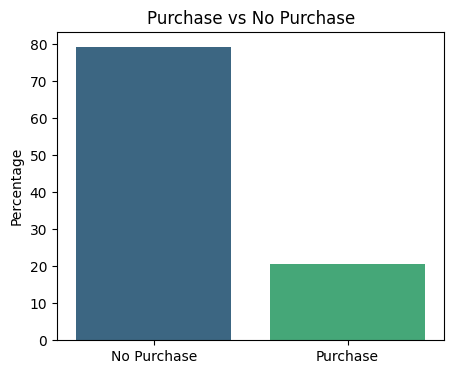

In [10]:
purchase_rate = (train_df['purchaseValue'] > 0).mean() * 100
print(f"Purchase Rate: {purchase_rate:.2f}%")

# Bar plot
plt.figure(figsize=(5, 4))
sns.barplot(x=['No Purchase', 'Purchase'], 
            y=[100-purchase_rate, purchase_rate], palette="viridis")
plt.ylabel("Percentage")
plt.title("Purchase vs No Purchase")
plt.show()


<h4>3. Key Takeaways and Modeling Implications</h4>
<ul>
    <li>
        <strong>Extreme Class Imbalance:</strong> The most critical insight is that the dataset is <strong>extremely imbalanced</strong>. The "No Purchase" class vastly outnumbers the "Purchase" class.
    </li>
    <li>
        <strong>Framing as a Classification Problem:</strong> This confirms that predicting whether a purchase will occur is a classic imbalanced classification problem. Standard accuracy would be a misleading metric, as a model that always predicts "No Purchase" would achieve a very high score while being completely useless.
    </li>
</ul>


## 2.2 Purchase Rate by Device Type

<h4>1. Why This Plot is Important</h4>
<p>
    After establishing the overall (and very low) purchase rate, the next logical step is to identify which user segments convert more effectively. This plot begins that process by segmenting users based on a critical feature: the <strong>device type</strong> they are using.
</p>
<p>
    The primary goal is to determine if there is a significant difference in purchasing behavior across different devices. This analysis helps to validate the predictive power of the <code>deviceType</code> feature and provides valuable insights that could inform both business strategy and feature engineering.
</p>

<h4>2. Explanation of the Plot</h4>
<p>
    This bar chart visualizes the conversion rate calculated for each unique device category.
</p>
<ul>
    <li><strong>Y-axis (Purchase Rate):</strong> Represents the percentage of sessions from a specific device type that resulted in a purchase (where <code>purchaseValue > 0</code>).</li>
    <li><strong>X-axis:</strong> Displays the different device types present in the dataset (e.g., Desktop, Mobile, Tablet).</li>
</ul>
<p>
    The bars are sorted, making it easy to instantly identify which devices have the highest and lowest conversion rates.
</p>

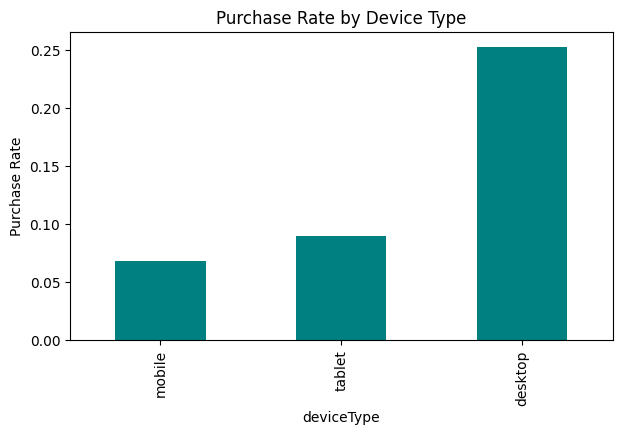

In [11]:
device_purchase = train_df.groupby('deviceType')['purchaseValue'].apply(lambda x: (x > 0).mean()).sort_values()
device_purchase.plot(kind='bar', figsize=(7,4), color='teal')
plt.ylabel("Purchase Rate")
plt.title("Purchase Rate by Device Type")
plt.show()


<h4>3. Key Takeaways and Implications</h4>
<ul>
    <li>
        <strong>Performance Variance:</strong> The plot clearly demonstrates that purchase behavior is <strong>not uniform</strong> across devices. This reveal that desktop users have a significantly higher purchase rate than mobile users.
    </li>
    <li>
        <strong>Feature Importance:</strong> This variance confirms that <code>deviceType</code> is a <strong>strong predictive feature</strong>. The clear difference in outcomes between the categories means this feature will likely be very valuable to the machine learning model.
    </li>
</ul>

## 2.3 Purchase Rate by Continent

<h4>1. Why This Plot is Important</h4>
<p>
    Following the analysis by device type, this plot continues the segmentation analysis by examining user behavior across different <strong>geographic locations</strong>. By grouping sessions by the <code>geoNetwork.continent</code> feature, we can investigate whether purchasing habits vary significantly around the world.
</p>
<p>
    This geographical analysis is crucial for understanding market differences and for validating the predictive power of location-based features. It helps answer the question: <strong>"Do users from certain continents convert at higher rates than others?"</strong>
</p>

<h4>2. Explanation of the Plot</h4>
<p>
    This bar chart visualizes the conversion rate calculated for each continent from which user sessions originated.
</p>
<ul>
    <li><strong>Y-axis (Purchase Rate):</strong> Represents the percentage of sessions from a specific continent that resulted in a purchase.</li>
    <li><strong>X-axis:</strong> Displays the different continents present in the dataset (e.g., Americas, Europe, Asia).</li>
</ul>
<p>
    By sorting the bars, the plot provides an immediate visual comparison, highlighting which regions are the most and least profitable in terms of conversion.
</p>

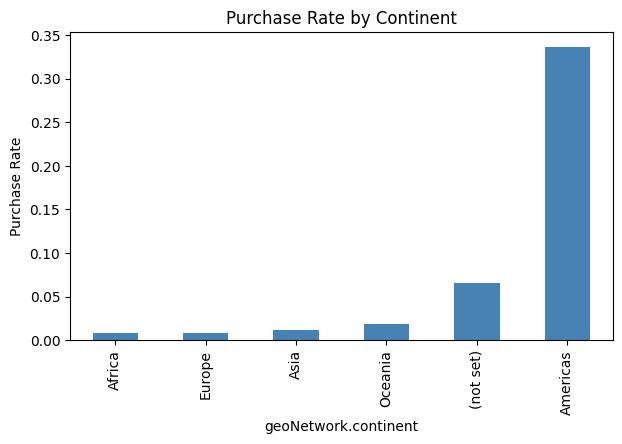

In [13]:
geo_purchase = train_df.groupby('geoNetwork.continent')['purchaseValue'].apply(lambda x: (x > 0).mean()).sort_values()
geo_purchase.plot(kind='bar', figsize=(7,4), color='steelblue')
plt.ylabel("Purchase Rate")
plt.title("Purchase Rate by Continent")
plt.show()


### Insights 

<h4>3. Key Takeaways and Implications</h4>
<ul>
    <li>
        <strong>Geographic Disparities:</strong> The plot confirms that purchase rate is <strong>not uniform globally</strong>. There are clear differences in consumer behavior depending on the continente.
    </li>
    <li>
        <strong>Feature Importance:</strong> The variation in conversion rates across continents demonstrates that <code>geoNetwork.continent</code> is a <strong>meaningful and predictive feature</strong>. This information will be valuable for the machine learning model to distinguish between users from different regions.
    </li>
    <li>
</ul>

## 2.4 Top 10 Columns with Missing Values

<h4>1. Why This Plot is Important</h4>
<p>
    A critical step in any data science project is to assess the completeness and quality of the data. Machine learning models cannot handle missing values (<code>NaN</code>) by default, and how we choose to deal with them can significantly impact the model's performance.
</p>
<p>
    This plot provides a quick and clear overview of the most problematic columns in the dataset by visualizing the proportion of missing data for the top 10 most affected features. This analysis is the foundation for building a robust data pre-processing and imputation strategy.
</p>

<h4>2. Explanation of the Plot</h4>
<p>
    This bar chart ranks the columns by their percentage of missing data, showing only the top 10.
</p>
<ul>
    <li><strong>Y-axis (Missing Value Ratio):</strong> Represents the proportion of missing values in a column, from 0.0 (0% missing) to 1.0 (100% missing).</li>
    <li><strong>X-axis:</strong> Displays the names of the columns with the highest missing value ratios.</li>
</ul>
<p>
    The height of each bar directly corresponds to the percentage of data that is missing for that feature, allowing for immediate identification of the most incomplete columns.
</p>

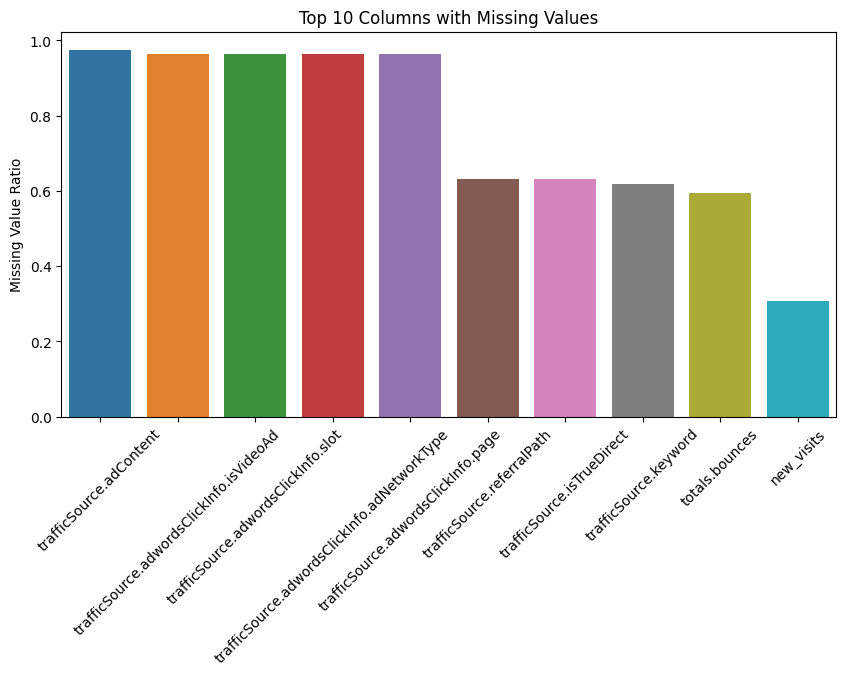

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

missing = train_df.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=missing.index[:10], y=missing.values[:10])
plt.xticks(rotation=45)
plt.ylabel("Missing Value Ratio")
plt.title("Top 10 Columns with Missing Values")
plt.show()


## 2.5 Top 10 Numeric Features Correlated with Purchase Value

<h4>1. Why This Plot is Important</h4>
<p>
    A crucial step in understanding the dataset is to identify which features have the strongest relationship with the target variable, <code>purchaseValue</code>. This plot specifically measures the <strong>linear relationship</strong> between each numerical feature and the purchase value.
</p>
<p>
    The goal is to quantify how much a feature's value tends to increase or decrease in tandem with the purchase value. Features with a high correlation coefficient are often strong predictors, especially for linear models, and this analysis provides a data-driven way to rank their potential importance.
</p>

<h4>2. Explanation of the Plot</h4>
<p>
    This bar chart displays the Pearson correlation coefficient for the top 10 numerical features that are most positively correlated with <code>purchaseValue</code>.
</p>
<ul>
    <li><strong>Y-axis:</strong> Lists the names of the top 10 numerical features.</li>
    <li><strong>X-axis (Correlation):</strong> Represents the Pearson correlation coefficient. A value closer to 1 indicates a strong positive linear relationship, while a value near 0 indicates little to no linear relationship.</li>
</ul>
<p>
    The coefficient is calculated using the following formula, where 'x' is the feature and 'y' is the target variable (purchaseValue):
</p>
<p style="font-family: 'Courier New', monospace; text-align: center; font-size: 1.1em;">
    r = &Sigma;((x<sub>i</sub> - x&#772;)(y<sub>i</sub> - y&#772;)) / &radic;[&Sigma;(x<sub>i</sub> - x&#772;)&sup2; &Sigma;(y<sub>i</sub> - y&#772;)&sup2;]
</p>
<p>
    In simpler terms, it measures the covariance of the two variables divided by the product of their standard deviations.
</p>
</ul>
<p>
    The length of each bar visually represents the strength of the linear association for that feature.
</p>

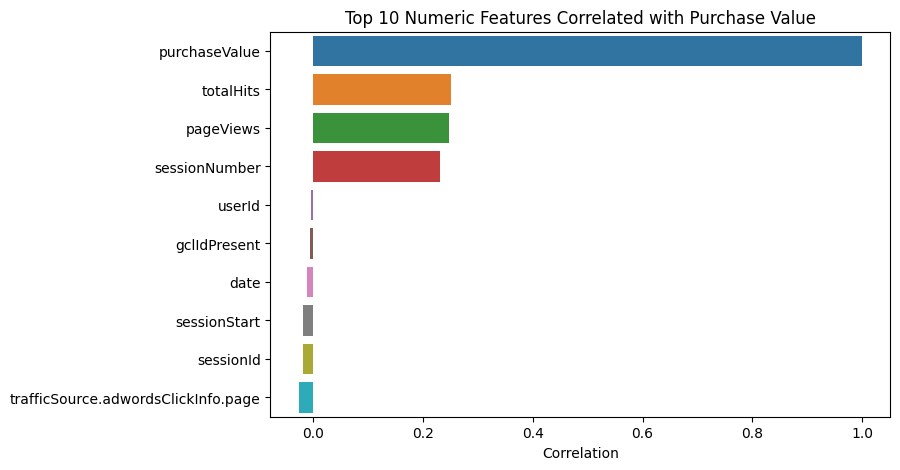

In [16]:
numeric_cols = train_df.select_dtypes(include=[np.number])
corr = numeric_cols.corrwith(train_df['purchaseValue']).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=corr.values[:10], y=corr.index[:10])
plt.title("Top 10 Numeric Features Correlated with Purchase Value")
plt.xlabel("Correlation")
plt.show()


## 2.6 Scatterplots with Numerical Columns

<h4>1. Why This Analysis is Important</h4>
<p>
    While correlation coefficients provide a single number to summarize a linear relationship, scatter plots offer a much richer, visual understanding of the interaction between two variables. This analysis aims to visualize the relationship between key numerical features (like <code>totalHits</code> and <code>pageViews</code>) and the target variable.
</p>
<p>
    Crucially, instead of plotting against the original <code>purchaseValue</code>, we are plotting against its <strong>log-transformed</strong> version (<code>log_purchaseValue</code>). This is done for two key reasons:
</p>
<ol>
    <li><strong>Handling Skewness:</strong> As seen in the previous histogram, the purchase values are heavily right-skewed. The log transformation compresses the y-axis, spreading out the clustered, low-value purchases and making underlying patterns much easier to discern.</li>
    <li><strong>Visualizing Non-Purchases:</strong> The <code>np.log1p</code> function transforms all zero-value purchases to zero (since log(1)=0). This means all non-converting sessions will lie neatly on a horizontal line at y=0, visually separating them from the converting sessions.</li>
</ol>

<h4>2. How to Interpret the Plots</h4>
<p>
    Each plot in this series shows the relationship between a specific numerical feature and the log-transformed purchase value.
</p>
<ul>
    <li><strong>X-axis:</strong> Represents the value of the numerical feature being analyzed (e.g., <code>totalHits</code>).</li>
    <li><strong>Y-axis:</strong> Represents the log of the purchase value. All the points lying on the line y=0 correspond to non-converting sessions.</li>
    <li><strong>Transparency (alpha=0.3):</strong> The points are made semi-transparent to help visualize their density. Darker areas indicate a high concentration of overlapping data points.</li>
</ul>

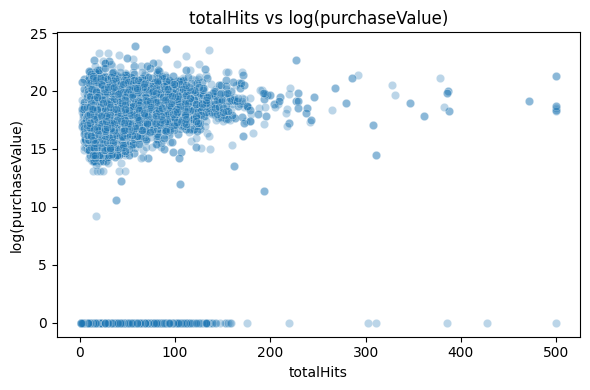

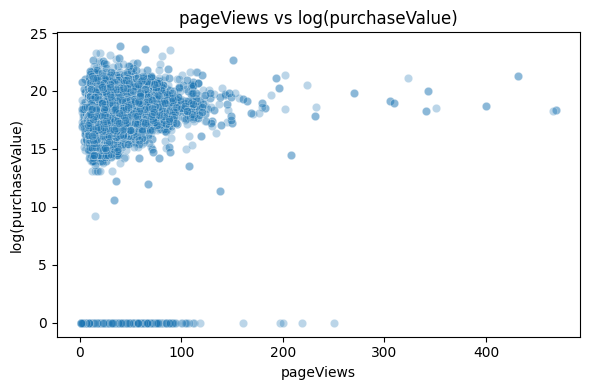

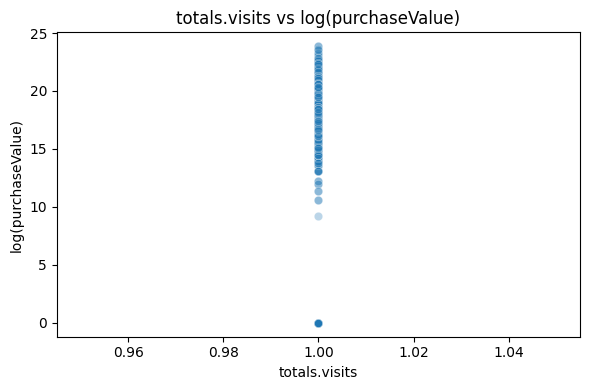

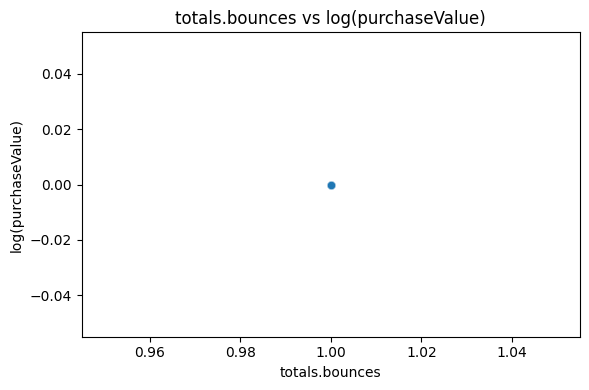

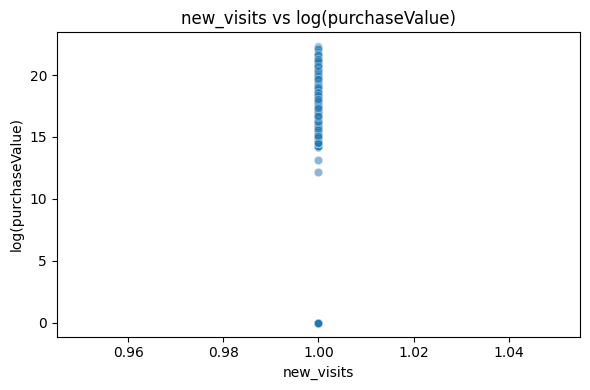

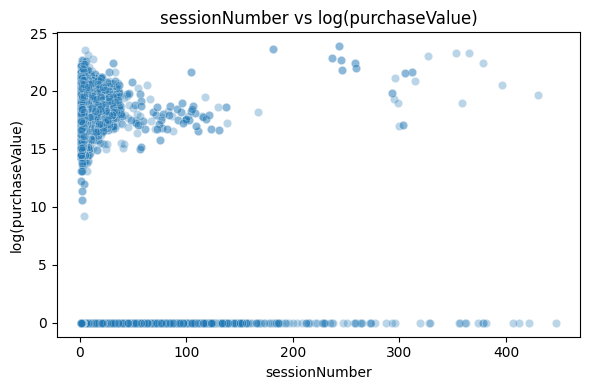

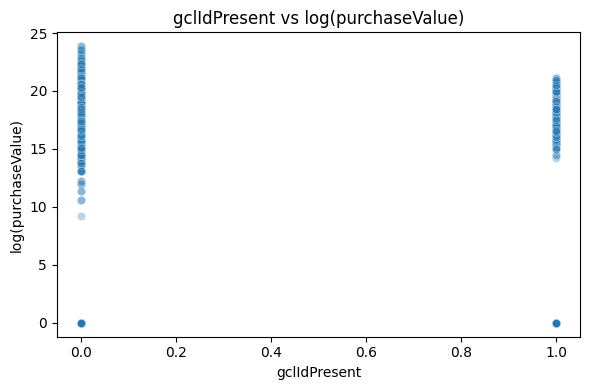

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
df["log_purchaseValue"] = np.log1p(df["purchaseValue"])

numerical_cols = ['totalHits', 'pageViews', 'totals.visits', 'totals.bounces', 'new_visits', 'sessionNumber', 'gclIdPresent']

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df["log_purchaseValue"], alpha=0.3)
    plt.title(f"{col} vs log(purchaseValue)")
    plt.xlabel(col)
    plt.ylabel("log(purchaseValue)")
    plt.tight_layout()
    plt.show()

# 2.7 Distribution of Numerical Features

<h4> How to Interpret the Plots</h4>
<p>
    Each histogram in the grid displays the frequency distribution for a single numerical feature.
</p>
<ul>
    <li><strong>X-axis:</strong> Represents the range of values for the feature.</li>
    <li><strong>Y-axis (Frequency):</strong> Represents the number of times a value within a certain range (or "bin") appears in the dataset.</li>
</ul>

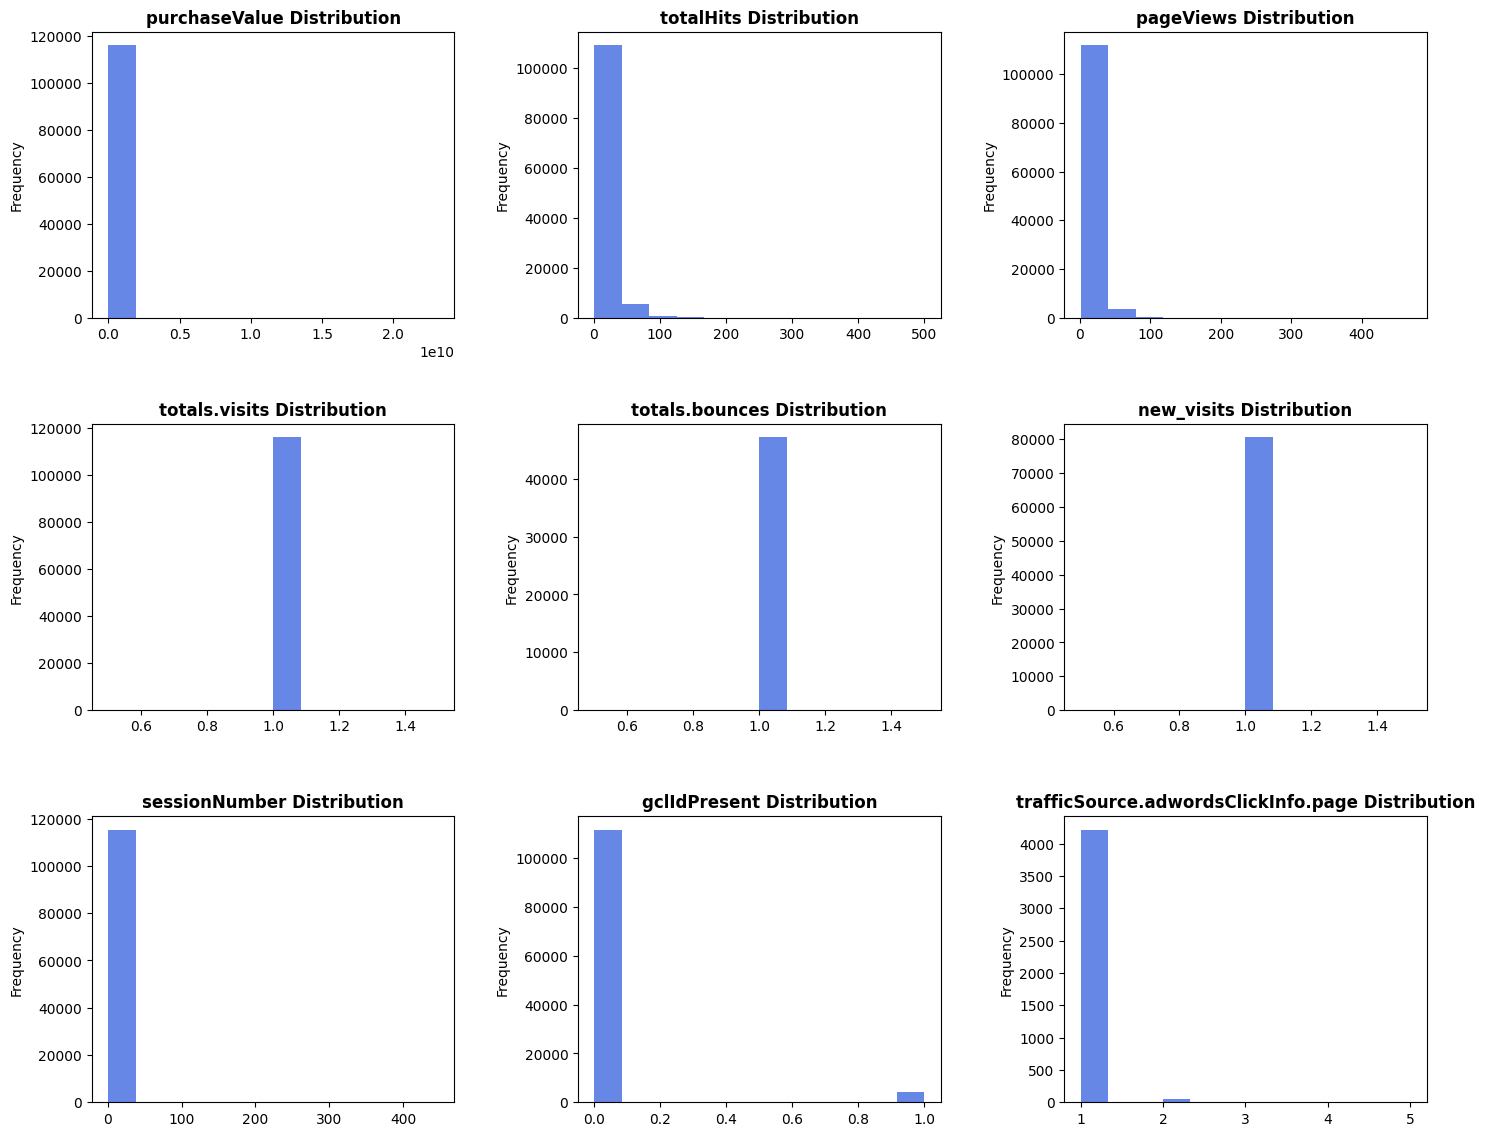

In [16]:
numerical_features = ['purchaseValue', 'totalHits', 'pageViews', 'totals.visits', 'totals.bounces', 'new_visits', 'sessionNumber', 'gclIdPresent','trafficSource.adwordsClickInfo.page']

fig, axes = plt.subplots(3, 3, figsize=(15, n_rows * 4))

axes = axes.flatten() 

for i, feature in enumerate(numerical_features):
    train_df[feature].plot(kind="hist", ax=axes[i], bins=12, color='royalblue', alpha=0.8)
    axes[i].set_title(f"{feature} Distribution", fontweight="bold")
    axes[i].set_ylabel("Frequency")

fig.tight_layout(pad=3.0)
plt.show()

# 2.8 Distribution of Categorical Features

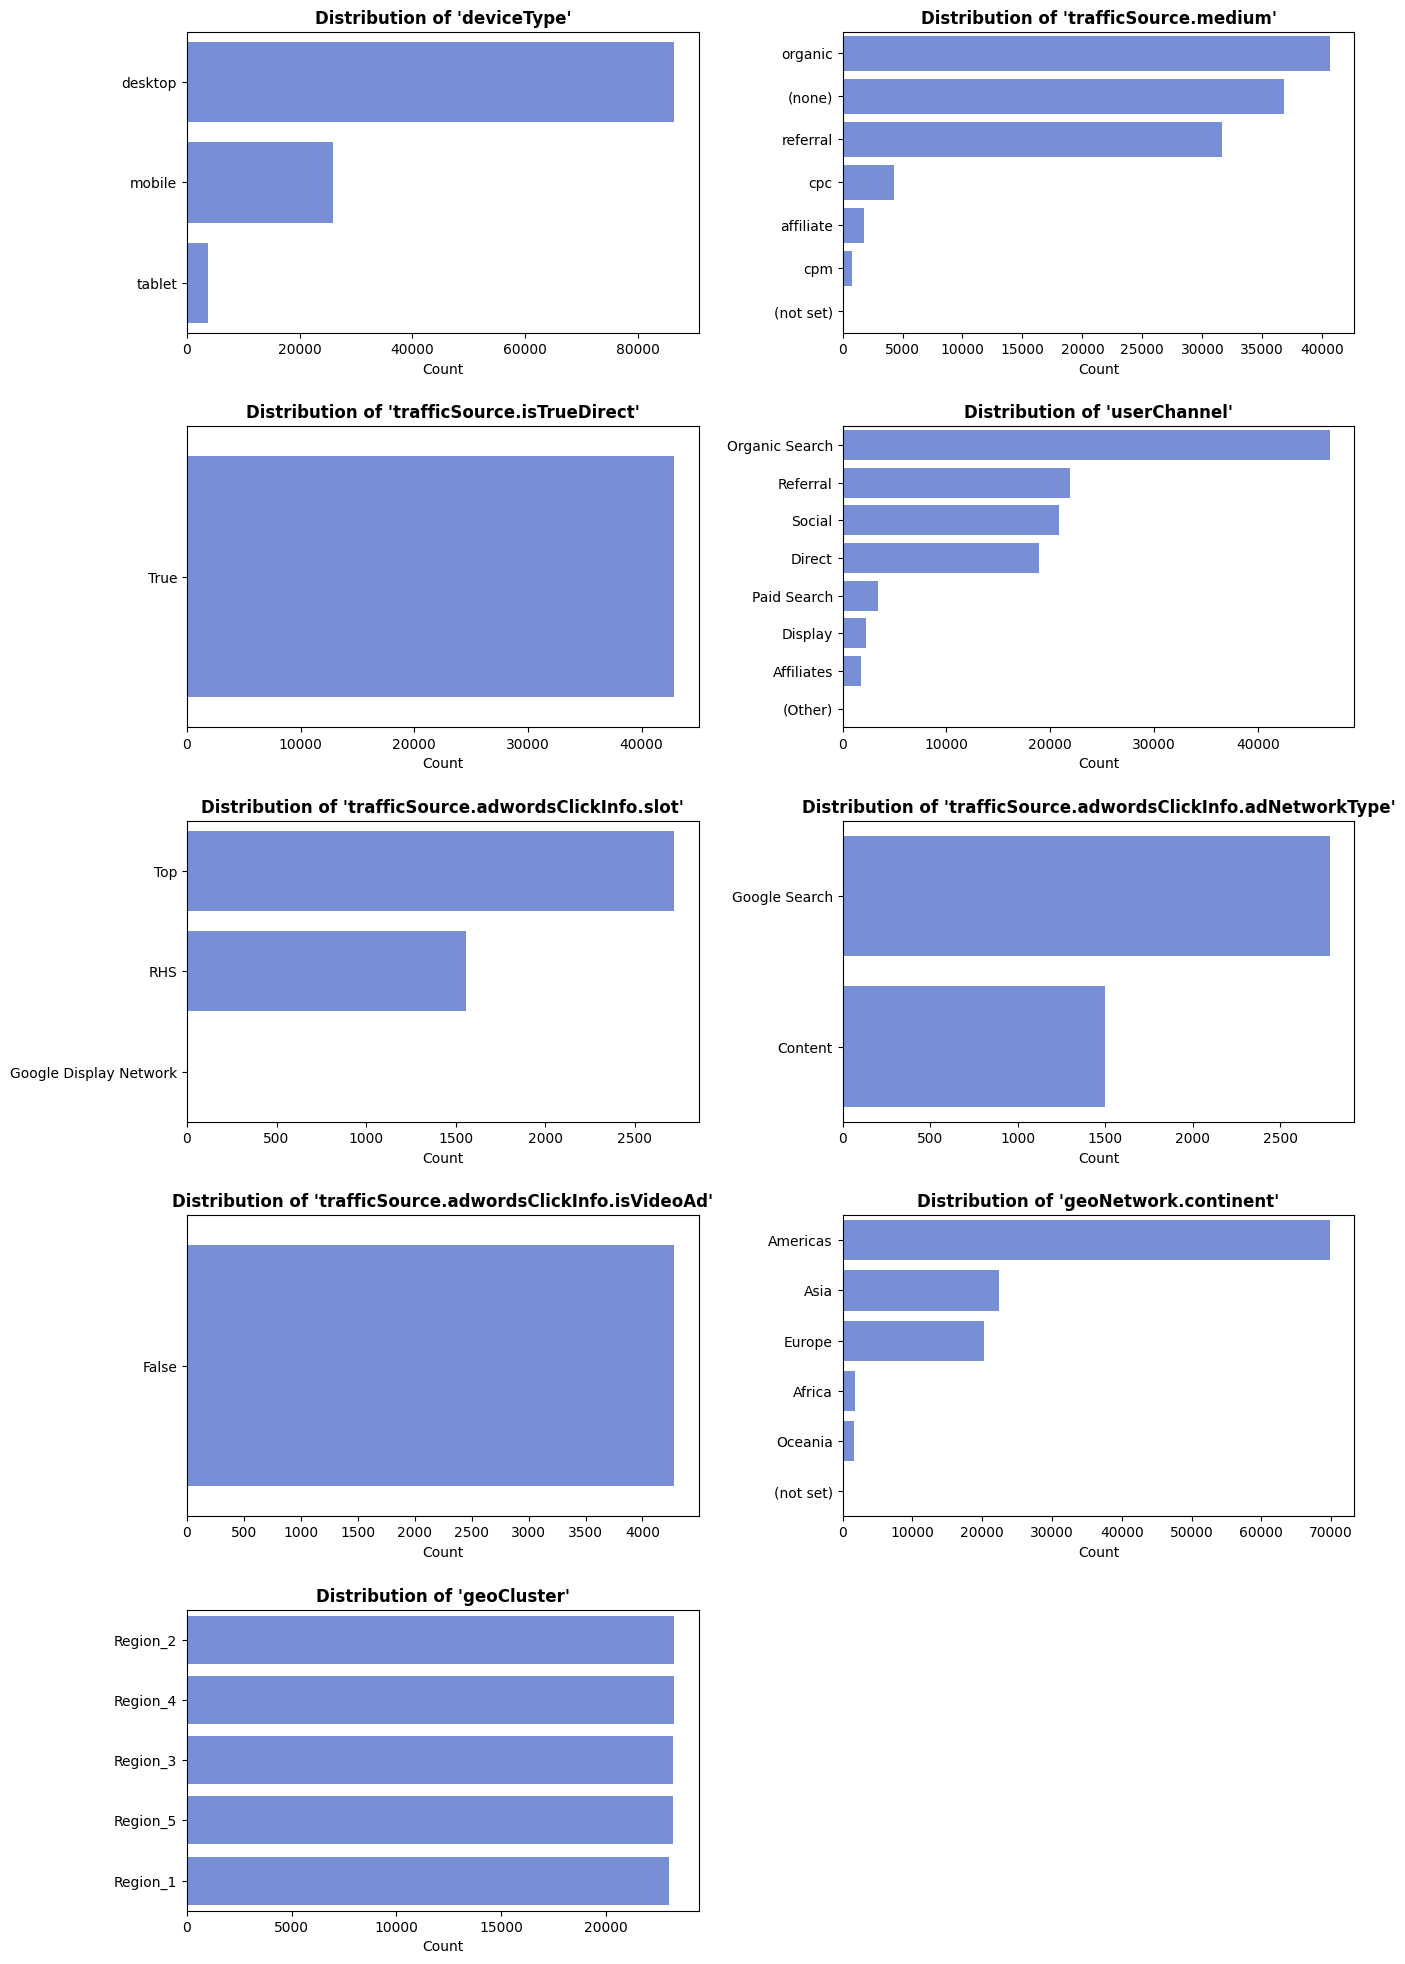

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

all_categorical_features = [
    'deviceType', 'trafficSource.medium', 'trafficSource.isTrueDirect',
    'userChannel', 'trafficSource.adwordsClickInfo.slot',
    'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd',
    'geoNetwork.continent', 'geoNetwork.subContinent', 'geoCluster'
]

filtered_features = [
    col for col in all_categorical_features
    if col in train_df.columns and train_df[col].nunique() <= 15
]

n_features = len(filtered_features)
n_cols = 2 
n_rows = (n_features + n_cols - 1) // n_cols

# --- 4. Create the plots ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
# Ensure axes is always a flattened array, even if n_rows=1
if n_rows == 1 and n_cols == 1:
    axes = np.array([axes])
axes = axes.flatten()

for i, feature in enumerate(filtered_features):
    # Ensure the column exists before plotting
    if feature in train_df.columns:
        sns.countplot(y=train_df[feature], ax=axes[i], order=train_df[feature].value_counts().index, color="royalblue", alpha=0.8)
        axes[i].set_title(f"Distribution of '{feature}'", fontweight="bold")
        axes[i].set_xlabel("Count")
        axes[i].set_ylabel("") # Hides the y-axis label

# --- 5. Hide any unused subplots ---
for i in range(n_features, len(axes)):
    axes[i].axis('off')

fig.tight_layout(pad=2.0)
plt.show()

# 3. Pre-Processing

## Initial Pre-processing Plan

<h4>User & Session Identifiers (5)</h4>
<ul>
    <li><strong>userId:</strong> <b>Drop Feature.</b> A unique identifier with no predictive value.</li>
    <li><strong>sessionId:</strong> <b>Drop Feature.</b> A unique identifier with no predictive value.</li>
    <li><strong>sessionNumber:</strong> <b>Standard Scaling.</b> A numerical feature indicating user loyalty.</li>
    <li><strong>sessionStart:</strong> <b>Feature Engineering.</b> Extract time-based features (hour, day of week), then drop the original.</li>
    <li><strong>date:</strong> <b>Feature Engineering.</b> Extract date-based features (day, month, year), then drop the original.</li>
</ul>

<h4>On-Site Behavior & Totals (6)</h4>
<ul>
    <li><strong>totals.visits:</strong> <b>Drop Feature.</b> The column has only one value (1).</li>
    <li><strong>totalHits:</strong> <b>Standard Scaling.</b> A key numerical feature for user engagement.</li>
    <li><strong>pageViews:</strong> <b>Standard Scaling.</b> A key numerical feature for engagement. Missing values to be imputed with the median.</li>
    <li><strong>totals.bounces:</strong> <b>Impute and Use.</b> Fill missing values with 0. It is a binary feature.</li>
    <li><strong>new_visits:</strong> <b>Impute and Use.</b> Fill missing values with 0. It is a binary feature.</li>
    <li><strong>socialEngagementType:</strong> <b>Drop Feature.</b> Very low variance; almost all values are "Not Socially Engaged".</li>
</ul>

<h4>Target Variable (1)</h4>
<ul>
    <li><strong>purchaseValue:</strong> <b>No Pre-processing.</b> This is the target variable. A log transformation could be considered if the distribution is skewed.</li>
</ul>

<h4>Traffic Source Features (8)</h4>
<ul>
    <li><strong>trafficSource:</strong> <b>Frequency Encoding.</b> A high-cardinality categorical feature.</li>
    <li><strong>trafficSource.medium:</strong> <b>One-Hot Encoding (OHE).</b> Low number of categories and an important predictor.</li>
    <li><strong>trafficSource.keyword:</strong> <b>Drop Feature.</b> High percentage of missing values and high cardinality.</li>
    <li><strong>trafficSource.adContent:</strong> <b>Drop Feature.</b> The vast majority of values are missing.</li>
    <li><strong>trafficSource.referralPath:</strong> <b>Drop Feature.</b> High cardinality and many missing values.</li>
    <li><strong>trafficSource.campaign:</strong> <b>Frequency Encoding.</b> High-cardinality categorical feature.</li>
    <li><strong>trafficSource.isTrueDirect:</strong> <b>Impute and Use.</b> Fill missing values with `False` and treat as a binary feature.</li>
    <li><strong>userChannel:</strong> <b>One-Hot Encoding (OHE).</b> A clean, low-cardinality categorical feature.</li>
</ul>

<h4>AdWords Campaign Features (5)</h4>
<ul>
    <li><strong>trafficSource.adwordsClickInfo.slot:</strong> <b>Drop Feature.</b> Over 95% missing values.</li>
    <li><strong>trafficSource.adwordsClickInfo.isVideoAd:</strong> <b>Drop Feature.</b> Over 95% missing values.</li>
    <li><strong>trafficSource.adwordsClickInfo.adNetworkType:</strong> <b>Drop Feature.</b> Over 95% missing values.</li>
    <li><strong>trafficSource.adwordsClickInfo.page:</strong> <b>Drop Feature.</b> Over 95% missing values.</li>
    <li><strong>gclIdPresent:</strong> <b>Use as is.</b> This is already a binary feature.</li>
</ul>

<h4>Geographic Features (10)</h4>
<ul>
    <li><strong>geoNetwork.continent:</strong> <b>One-Hot Encoding (OHE).</b> Low cardinality and a strong signal.</li>
    <li><strong>geoNetwork.subContinent:</strong> <b>One-Hot Encoding (OHE).</b> Low cardinality.</li>
    <li><strong>locationCountry:</strong> <b>Frequency Encoding.</b> High cardinality, but contains important information.</li>
    <li><strong>geoNetwork.region:</strong> <b>Frequency Encoding.</b> High cardinality.</li>
    <li><strong>geoNetwork.metro:</strong> <b>Frequency Encoding.</b> High cardinality.</li>
    <li><strong>geoNetwork.city:</strong> <b>Frequency Encoding.</b> Very high cardinality.</li>
    <li><strong>geoNetwork.networkDomain:</strong> <b>Frequency Encoding.</b> Very high cardinality.</li>
    <li><strong>geoNetwork.networkLocation:</strong> <b>Drop Feature.</b> Redundant with other geo features.</li>
    <li><strong>geoCluster:</strong> <b>One-Hot Encoding (OHE).</b> A low-cardinality categorical feature.</li>
    <li><strong>locationZone:</strong> <b>Frequency Encoding.</b> High cardinality.</li>
</ul>

<h4>Device & Browser Features (17)</h4>
<ul>
    <li><strong>os:</strong> <b>One-Hot Encoding (OHE).</b> Low cardinality.</li>
    <li><strong>deviceType:</strong> <b>One-Hot Encoding (OHE).</b> Important, low-cardinality feature.</li>
    <li><strong>browser:</strong> <b>Frequency Encoding.</b> High cardinality, but a potentially useful feature.</li>
    <li><strong>browserMajor:</strong> <b>Drop Feature.</b> Redundant with the `browser` feature.</li>
    <li><strong>device.browserVersion:</strong> <b>Drop Feature.</b> Too many unique values.</li>
    <li><strong>device.operatingSystemVersion:</strong> <b>Drop Feature.</b> Too many unique values.</li>
    <li><strong>device.isMobile:</strong> <b>Use as is.</b> Already a binary feature.</li>
    <li><strong>device.mobileDeviceBranding:</strong> <b>Drop Feature.</b> Dominated by "not available".</li>
    <li><strong>device.mobileDeviceMarketingName:</strong> <b>Drop Feature.</b> Dominated by "not available".</li>
    <li><strong>device.mobileDeviceModel:</strong> <b>Drop Feature.</b> Dominated by "not available".</li>
    <li><strong>device.mobileInputSelector:</strong> <b>Drop Feature.</b> Dominated by "not available".</li>
    <li><strong>device.screenResolution:</strong> <b>Drop Feature.</b> High cardinality and dominated by "not available".</li>
    <li><strong>screenSize:</strong> <b>Drop Feature.</b> High cardinality and dominated by "not available".</li>
    <li><strong>device.browserSize:</strong> <b>Drop Feature.</b> High cardinality and dominated by "not available".</li>
    <li><strong>device.flashVersion:</strong> <b>Drop Feature.</b> Legacy technology and dominated by "not available".</li>
    <li><strong>device.screenColors:</strong> <b>Drop Feature.</b> Dominated by "not available".</li>
    <li><strong>device.language:</strong> <b>Drop Feature.</b> Dominated by "not available".</li>
</ul>

In [3]:
"""import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

train = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")

all_data = pd.concat([train, test], sort=False).reset_index(drop=True)

drop_cols = [
    'userId', 'sessionId', 'totals.visits', 'socialEngagementType',
    'trafficSource.keyword', 'trafficSource.adContent', 'trafficSource.referralPath',
    'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.isVideoAd',
    'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.page',
    'browserMajor', 'device.browserVersion', 'device.operatingSystemVersion',
    'device.mobileDeviceBranding', 'device.mobileDeviceMarketingName',
    'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.screenResolution',
    'screenSize', 'device.browserSize', 'device.flashVersion', 'device.screenColors',
    'device.language', 'geoNetwork.networkLocation'
]
all_data.drop(columns=[col for col in drop_cols if col in all_data.columns], inplace=True)

if 'sessionStart' in all_data.columns:
    all_data['sessionStart'] = pd.to_datetime(all_data['sessionStart'], errors='coerce')
    all_data['sessionHour'] = all_data['sessionStart'].dt.hour
    all_data['sessionWeekday'] = all_data['sessionStart'].dt.weekday
    all_data.drop(columns=['sessionStart'], inplace=True)

if 'date' in all_data.columns:
    all_data['date'] = pd.to_datetime(all_data['date'], errors='coerce')
    all_data['day'] = all_data['date'].dt.day
    all_data['month'] = all_data['date'].dt.month
    all_data['year'] = all_data['date'].dt.year
    all_data.drop(columns=['date'], inplace=True)

scale_cols = ['sessionNumber', 'totalHits', 'pageViews']
for col in scale_cols:
    if col in all_data.columns:
        all_data[col].fillna(all_data[col].median(), inplace=True)
        all_data[col] = StandardScaler().fit_transform(all_data[[col]])

for col in ['totals.bounces', 'new_visits']:
    if col in all_data.columns:
        all_data[col].fillna(0, inplace=True)

if 'trafficSource.isTrueDirect' in all_data.columns:
    all_data['trafficSource.isTrueDirect'].fillna(False, inplace=True)

freq_enc_cols = [
    'trafficSource', 'trafficSource.campaign', 'locationCountry',
    'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
    'geoNetwork.networkDomain', 'locationZone', 'browser'
]
for col in freq_enc_cols:
    if col in all_data.columns:
        freq_map = all_data[col].value_counts(normalize=True)
        all_data[col] = all_data[col].map(freq_map)

ohe_cols = [
    'trafficSource.medium', 'userChannel', 'geoNetwork.continent',
    'geoNetwork.subContinent', 'geoCluster', 'os', 'deviceType'
]
available_ohe_cols = [col for col in ohe_cols if col in all_data.columns]
if available_ohe_cols:
    all_data = pd.get_dummies(all_data, columns=available_ohe_cols, drop_first=True)

X_train = all_data.iloc[:len(train)].copy()
X_test = all_data.iloc[len(train):].copy()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
"""

'import pandas as pd\nimport numpy as np\nfrom sklearn.preprocessing import StandardScaler\n\ntrain = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")\ntest = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")\n\nall_data = pd.concat([train, test], sort=False).reset_index(drop=True)\n\ndrop_cols = [\n    \'userId\', \'sessionId\', \'totals.visits\', \'socialEngagementType\',\n    \'trafficSource.keyword\', \'trafficSource.adContent\', \'trafficSource.referralPath\',\n    \'trafficSource.adwordsClickInfo.slot\', \'trafficSource.adwordsClickInfo.isVideoAd\',\n    \'trafficSource.adwordsClickInfo.adNetworkType\', \'trafficSource.adwordsClickInfo.page\',\n    \'browserMajor\', \'device.browserVersion\', \'device.operatingSystemVersion\',\n    \'device.mobileDeviceBranding\', \'device.mobileDeviceMarketingName\',\n    \'device.mobileDeviceModel\', \'device.mobileInputSelector\', \'device.screenResolution\',\n    \'screen

X_train shape: (116023, 86)

X_test shape: (29006, 86)

## 3.1 Selecting Relevant Columns

In [12]:
relevant_columns = [
    'userId', 'totalHits', 'pageViews', 'totals.visits', 'totals.bounces', 'new_visits',
    'sessionNumber', 'sessionStart', 'date',
    'deviceType', 'os', 'device.isMobile',
    'trafficSource', 'trafficSource.medium', 'trafficSource.campaign', 'trafficSource.keyword',
    'trafficSource.adContent', 'trafficSource.referralPath', 'trafficSource.isTrueDirect',
    'userChannel', 'gclIdPresent', 'trafficSource.adwordsClickInfo.slot',
    'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd',
    'locationCountry', 'geoNetwork.city', 'geoNetwork.region', 'geoNetwork.continent',
    'geoNetwork.subContinent', 'geoCluster', 'geoNetwork.metro',
    'purchaseValue'
]

print(len(relevant_columns))
train_df = train_df[[c for c in relevant_columns if c in train_df.columns]]
test_df = test_df[[c for c in relevant_columns if c != 'purchaseValue' and c in test_df.columns]]

print(train_df.shape)

train_df.head()

32
(116023, 32)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,userId,totalHits,pageViews,totals.visits,totals.bounces,new_visits,sessionNumber,sessionStart,date,deviceType,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,locationCountry,geoNetwork.city,geoNetwork.region,geoNetwork.continent,geoNetwork.subContinent,geoCluster,geoNetwork.metro,purchaseValue
0,61421,1,1.0,1,1.0,1.0,1,1500100799,20170714,desktop,...,NaN,NaN,United States,Redmond,Washington,Americas,Northern America,Region_2,Seattle-Tacoma WA,0.0
1,72287,1,1.0,1,1.0,1.0,1,1495262065,20170519,desktop,...,NaN,NaN,United States,Mountain View,California,Americas,Northern America,Region_3,San Francisco-Oakland-San Jose CA,0.0
2,25180,6,6.0,1,NaN,NaN,2,1508510328,20171020,desktop,...,NaN,NaN,Italy,Milan,Lombardy,Europe,Southern Europe,Region_2,(not set),0.0
3,41295,1,1.0,1,1.0,1.0,1,1483431838,20170103,desktop,...,NaN,NaN,Japan,not available in demo dataset,not available in demo dataset,Asia,Eastern Asia,Region_4,not available in demo dataset,0.0
4,113697,66,54.0,1,NaN,1.0,1,1475804633,20161006,desktop,...,NaN,NaN,United States,not available in demo dataset,not available in demo dataset,Americas,Northern America,Region_3,not available in demo dataset,88950000.0


In [13]:
train_df.columns

Index(['userId', 'totalHits', 'pageViews', 'totals.visits', 'totals.bounces',
       'new_visits', 'sessionNumber', 'sessionStart', 'date', 'deviceType',
       'os', 'device.isMobile', 'trafficSource', 'trafficSource.medium',
       'trafficSource.campaign', 'trafficSource.keyword',
       'trafficSource.adContent', 'trafficSource.referralPath',
       'trafficSource.isTrueDirect', 'userChannel', 'gclIdPresent',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd', 'locationCountry',
       'geoNetwork.city', 'geoNetwork.region', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoCluster', 'geoNetwork.metro',
       'purchaseValue'],
      dtype='object')

## 3.2 Preprocessing Timestamp Columns

In [14]:
print(train_df['date'].head(10))
print(train_df['date'].dtype)

0    20170714
1    20170519
2    20171020
3    20170103
4    20161006
5    20170915
6    20160824
7    20170328
8    20170525
9    20170723
Name: date, dtype: int64
int64


In [15]:
def preprocess(df):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d', errors='coerce')
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['dayofweek'] = df['date'].dt.dayofweek
        df.drop('date', axis=1, inplace=True)

    if 'sessionStart' in df.columns:
        df['sessionStart'] = pd.to_datetime(df['sessionStart'], unit='s', errors='coerce')
        df['session_hour'] = df['sessionStart'].dt.hour.fillna(0).astype(int)
        df['session_minute'] = df['sessionStart'].dt.minute.fillna(0).astype(int)
        df.drop('sessionStart', axis=1, inplace=True)

    if 'device.isMobile' in df.columns:
        df['device.isMobile'] = df['device.isMobile'].astype(float)
    
    return df

before_cols = set(train_df.columns)
train_df = preprocess(train_df)
after_cols = set(train_df.columns)

print("Columns added:", after_cols - before_cols)
print("Columns removed:", before_cols - after_cols)
print("Shape after preprocess:", train_df.shape)


Columns added: {'session_hour', 'day', 'session_minute', 'dayofweek', 'month', 'year'}
Columns removed: {'sessionStart', 'date'}
Shape after preprocess: (116023, 36)


In [16]:
test_df = preprocess(test_df)

Output : 

Columns added: {'month', 'session_hour', 'dayofweek', 'day', 'session_minute', 'year'}

Columns removed: {'sessionStart', 'date'}

Shape after preprocess: (116023, 36)

## 3.3 Feature Engineering (Creating New Features)

<h4>Newly Engineered Features (5):</h4>
<ul>
    <li><strong>hits_per_view:</strong> This measures the average number of interactions (hits) per page view in a session. A higher value might suggest more complex engagement on each page, such as events or transactions, beyond simple viewing.</li>
    <li><strong>bounce_rate:</strong> Calculates the proportion of sessions that were bounces. Since `totals.visits` is always 1, this feature is essentially the same as the original `totals.bounces` column but normalized. It directly quantifies session abandonment.</li>
    <li><strong>user_avg_pv:</strong> This feature assigns the historical average purchase value to each user. It's a powerful way to embed past purchasing behavior directly into the model. For users in the test set not seen during training, the overall average purchase value is used.</li>
    <li><strong>is_first_session:</strong> A binary flag (1 for yes, 0 for no) that indicates if the current session is the user's first-ever session recorded in the data. This helps the model differentiate the behavior of new vs. returning users.</li>
    <li><strong>normalized_session:</strong> This normalizes the session number for each user based on their total number of sessions. It represents how far along a user is in their journey on a scale from 0 to 1, providing a relative measure of user experience.</li>
</ul>

In [17]:
train_df['hits_per_view'] = train_df['totalHits'] / (train_df['pageViews'] + 1)
test_df['hits_per_view'] = test_df['totalHits'] / (test_df['pageViews'] + 1)

train_df['bounce_rate'] = train_df['totals.bounces'] / (train_df['totals.visits'] + 1)
test_df['bounce_rate'] = test_df['totals.bounces'] / (test_df['totals.visits'] + 1)

user_avg_pv = train_df.groupby('userId')['purchaseValue'].mean()
train_df['user_avg_pv'] = train_df['userId'].map(user_avg_pv)
test_df['user_avg_pv'] = test_df['userId'].map(user_avg_pv)
test_df['user_avg_pv'].fillna(train_df['purchaseValue'].mean(), inplace=True)

user_min_session = train_df.groupby('userId')['sessionNumber'].min()
train_df['is_first_session'] = (train_df['sessionNumber'] == train_df['userId'].map(user_min_session)).astype(int)
test_df['is_first_session'] = (test_df['sessionNumber'] == test_df['userId'].map(user_min_session)).astype(int)

user_max_session = train_df.groupby('userId')['sessionNumber'].max()
train_df['normalized_session'] = train_df['sessionNumber'] / (train_df['userId'].map(user_max_session) + 1e-6)
test_df['normalized_session'] = test_df['sessionNumber'] / (test_df['userId'].map(user_max_session) + 1e-6)

print(train_df.shape)

(116023, 41)


/tmp/ipykernel_35/3991888196.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['user_avg_pv'].fillna(train_df['purchaseValue'].mean(), inplace=True)


In [18]:
y_train_reg = train_df['purchaseValue']
y_train_cls = (train_df['purchaseValue'] > 0).astype(int)

X_train = train_df.drop(columns=['purchaseValue'])
X_test = test_df

print(X_train.shape)

(116023, 40)


## 3.4 Column Grouping & Frequency Encoding

<h3>Data Pre-processing and Feature Transformation</h3>

<h4>1. Strategy Overview</h4>
<p>
    After cleaning the data and performing initial feature engineering, the next critical step is to transform the features into a format suitable for machine learning algorithms. The strategy involves categorizing each feature based on its data type and cardinality, and then applying a specific transformation technique to each group.
</p>

<h4>2. Feature Categorization</h4>
<p>
    The first step was to systematically classify all features into one of five distinct groups:
</p>
<ul>
    <li><b>Numerical:</b> Standard numeric features that will be scaled.</li>
    <li><b>Datetime:</b> Features engineered from date/time columns.</li>
    <li><b>Boolean:</b> True/False features.</li>
    <li><b>Categorical (Low-Cardinality):</b> Categorical features with a small number of unique values.</li>
    <li><b>Categorical (High-Cardinality):</b> Categorical features with a large number of unique values.</li>
</ul>
<p>
    This separation allows for the application of tailored pre-processing pipelines to each group.
</p>

<h4>3. Handling High-Cardinality Categorical Features</h4>
<p>
    <b>The Challenge:</b> Features like <code>locationCountry</code> or <code>geoNetwork.city</code> have hundreds or thousands of unique values. Using standard One-Hot Encoding on these would lead to the "curse of dimensionality," creating an unmanageable number of new columns and making the model difficult to train.
</p>
<p>
    <b>The Solution: Frequency Encoding.</b> To handle this, <strong>Frequency Encoding</strong> was implemented. This technique involves the following steps:
</p>
<ol>
    <li>Calculate the frequency (or percentage) of each unique category in the training set.</li>
    <li>Replace each category in both the training and test sets with its corresponding frequency.</li>
    <li>The original high-cardinality columns are then dropped, and the new frequency-encoded columns are treated as numerical features.</li>
</ol>
<p>
    This method effectively converts these complex categorical features into a single numerical feature that captures the relative importance or rarity of each category, without exploding the feature space.
</p>

<h4>4. Handling Low-Cardinality and Other Features</h4>
<p>
    <b>Low-Cardinality Features:</b> The code converts these columns to string format. This is a preparatory step for a Scikit-learn pipeline (like <code>ColumnTransformer</code>), where <strong>One-Hot Encoding</strong> will be applied. This is the standard and most effective method for features with few categories.
</p>
<p>
    <b>Numerical and Boolean Features:</b> These features are already in a usable format. The numerical features will be passed to a scaler (like <code>StandardScaler</code>) within the final pipeline to normalize their ranges, which is essential for many machine learning algorithms.
</p>

In [19]:
numerical_cols = [
    'totalHits', 'pageViews', 'totals.visits', 'totals.bounces', 'new_visits',
    'sessionNumber', 'gclIdPresent', 'session_hour', 'session_minute',
    'user_avg_pv', 'hits_per_view', 'bounce_rate', 'normalized_session'
]
datetime_cols = ['year', 'month', 'day', 'dayofweek']
boolean_cols = ['device.isMobile', 'is_first_session']
categorical_cols = [
    'deviceType', 'trafficSource.medium', 'trafficSource.isTrueDirect',
    'userChannel', 'trafficSource.adwordsClickInfo.slot',
    'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd',
    'geoNetwork.continent', 'geoNetwork.subContinent', 'geoCluster'
]

high_card_cols = [
    'trafficSource', 'trafficSource.campaign', 'trafficSource.keyword',
    'trafficSource.adContent', 'trafficSource.referralPath',
    'locationCountry', 'geoNetwork.city', 'geoNetwork.region', 'geoNetwork.metro'
]
for col in high_card_cols:
    if col in X_train.columns:
        freq = X_train[col].value_counts(normalize=True)
        X_train[col + '_freq'] = X_train[col].map(freq)
        X_test[col + '_freq'] = X_test[col].map(freq).fillna(0)
        X_train.drop(columns=[col], inplace=True)
        X_test.drop(columns=[col], inplace=True)
        numerical_cols.append(col + '_freq')

for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)



## 3.5 Preprocessing Pipelines (Scaling and Encoding)

In [22]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

bool_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

date_pipe = Pipeline([
    ('scaler', StandardScaler())
])

## 3.6 ColumnTransformer & Final Data

In [23]:
preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical_cols),
    ('cat', cat_pipe, categorical_cols),
    ('bool', bool_pipe, boolean_cols),
    ('date', date_pipe, datetime_cols)
])

X_train.columns

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Processed train shape:", X_train_proc.shape)
print("Processed test shape:", X_test_proc.shape)

Processed train shape: (116023, 91)
Processed test shape: (29006, 91)


In [24]:
feature_names = list(numerical_cols)

cat_ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_feature_names = cat_ohe.get_feature_names_out(categorical_cols)
feature_names.extend(cat_feature_names)

feature_names.extend(boolean_cols)

feature_names.extend(datetime_cols)

print("Total features:", len(feature_names))
print("Features:", feature_names[:])  


Total features: 91
Features: ['totalHits', 'pageViews', 'totals.visits', 'totals.bounces', 'new_visits', 'sessionNumber', 'gclIdPresent', 'session_hour', 'session_minute', 'user_avg_pv', 'hits_per_view', 'bounce_rate', 'normalized_session', 'trafficSource_freq', 'trafficSource.campaign_freq', 'trafficSource.keyword_freq', 'trafficSource.adContent_freq', 'trafficSource.referralPath_freq', 'locationCountry_freq', 'geoNetwork.city_freq', 'geoNetwork.region_freq', 'geoNetwork.metro_freq', 'deviceType_desktop', 'deviceType_mobile', 'deviceType_tablet', 'trafficSource.medium_(none)', 'trafficSource.medium_(not set)', 'trafficSource.medium_affiliate', 'trafficSource.medium_cpc', 'trafficSource.medium_cpm', 'trafficSource.medium_organic', 'trafficSource.medium_referral', 'trafficSource.isTrueDirect_True', 'trafficSource.isTrueDirect_nan', 'userChannel_(Other)', 'userChannel_Affiliates', 'userChannel_Direct', 'userChannel_Display', 'userChannel_Organic Search', 'userChannel_Paid Search', 'userC

# 4. Models

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_proc, y_train_reg, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (92818, 91)
Validation shape: (23205, 91)


## 4.1 Trying 5 different Regressors 

<h3>Baseline Model Selection Strategy</h3>

<h4>1. The Goal: Establishing a Strong Baseline</h4>
<p>
    Before proceeding to advanced techniques like hyperparameter tuning and stacking, it is crucial to establish a strong performance baseline. To achieve this, a diverse set of five different regression models was selected for initial evaluation. The goal was not just to pick one model, but to test algorithms from different families to understand which approach works best for this specific dataset. This strategy minimizes the risk of prematurely committing to a suboptimal model architecture.
</p>

<h4>2. Justification for Model Choices</h4>
<p>
    The chosen models represent three distinct families of machine learning algorithms: bagging ensembles, boosting ensembles, and instance-based learning.
</p>
<ul>
    <li>
        <strong>RandomForestRegressor:</strong> This is a robust and widely used <b>bagging</b> ensemble model. It works by building multiple decision trees on different sub-samples of the data and averaging their predictions. Its inclusion is essential because it is excellent at capturing complex non-linear relationships and is naturally resistant to overfitting.
    </li>
    <li>
        <strong>GradientBoostingRegressor & XGBoost:</strong> These two models represent the <b>boosting</b> family. Unlike Random Forest, boosting models build trees sequentially, where each new tree corrects the errors of the previous one.
        <ul>
            <li><b>GradientBoostingRegressor</b> is the classic implementation of this technique.</li>
            <li><b>XGBoost</b> (Extreme Gradient Boosting) is a more recent, highly optimized version that includes built-in regularization, which often leads to superior performance and better control over overfitting. Including both helps compare the classic approach with its state-of-the-art successor.</li>
        </ul>
    </li>
    <li>
        <strong>ExtraTreesRegressor:</strong> This model, or "Extremely Randomized Trees," is a variation of Random Forest. While it also builds a forest of trees, it introduces more randomness by selecting split points completely at random for each feature, rather than searching for the optimal split. This can sometimes reduce model variance and provide a good alternative if Random Forest is overfitting.
    </li>
    <li>
        <strong>KNeighborsRegressor (KNN):</strong> This model was chosen because it is fundamentally different from the tree-based ensembles. KNN is an <b>instance-based</b> (or non-parametric) algorithm that makes predictions based on the average value of its 'k' nearest neighbors in the feature space. Its inclusion serves as a critical test to see if a simple, distance-based approach could potentially outperform more complex ensemble methods on this dataset.
    </li>
</ul>

<h4>3. Conclusion of Baseline Evaluation</h4>
<p>
    By evaluating these five models, a comprehensive understanding of how different algorithmic approaches handle the data can be achieved. The results from this initial run will guide the selection of the most promising model(s) to carry forward for more intensive hyperparameter tuning and final deployment.
</p>

In [31]:
"""from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

model_r2_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    model_r2_scores[name] = r2
    print(f"{name} R² Score: {r2:.4f}")
"""

RandomForest R² Score: 0.6519
XGBoost R² Score: 0.6231
GradientBoosting R² Score: 0.6904
ExtraTrees R² Score: 0.7455
KNN R² Score: 0.5078


In [32]:
"""import pandas as pd

results_df = pd.DataFrame(list(model_r2_scores.items()), columns=["Model", "R2_Score"])
results_df = results_df.sort_values(by="R2_Score", ascending=False).reset_index(drop=True)
print(results_df)
"""

              Model  R2_Score
0        ExtraTrees  0.745501
1  GradientBoosting  0.690441
2      RandomForest  0.651928
3           XGBoost  0.623094
4               KNN  0.507831


## 4.2 ExtraTrees Regressor

In [21]:
"""from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score

etr = ExtraTreesRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

etr.fit(X_train, y_train)

val_preds = etr.predict(X_val)
val_r2 = r2_score(y_val, val_preds)
print(f"{val_r2:.5f}")

test_preds = etr.predict(X_test_proc)
test_preds = np.maximum(test_preds, 0)

sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")
sample_submission["purchaseValue"] = test_preds
sample_submission = sample_submission.rename(columns={"ID": "id"})
sample_submission.to_csv("submission.csv", index=False)

print("submission.csv")
print(sample_submission.head(10))
"""

0.73207
submission.csv
   id  purchaseValue
0   0     34698950.0
1   1     33780400.0
2   2       280800.0
3   3      4192800.0
4   4     17436750.0
5   5     78540300.0
6   6    191036500.0
7   7            0.0
8   8      7042150.0
9   9     17072800.0


## 4.3 GradientBoosting Regressor

In [24]:
"""from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

gbr = GradientBoostingRegressor(
    n_estimators=300,      
    learning_rate=0.05,    
    max_depth=5,           
    random_state=42
)

gbr.fit(X_train_proc, y_train_reg)

val_preds = gbr.predict(X_val)
val_r2 = r2_score(y_val, val_preds)
print(f"{val_r2:.5f}")

test_preds = gbr.predict(X_test_proc)

test_preds = np.maximum(test_preds, 0)

sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")
sample_submission["purchaseValue"] = test_preds
sample_submission = sample_submission.rename(columns={"ID": "id"})
sample_submission.to_csv("submission.csv", index=False)

print("Final submission saved as 'submission.csv'")
print(sample_submission.head(10))
"""

0.98300
Final submission saved as 'submission.csv'
   id  purchaseValue
0   0   3.441845e+07
1   1   2.683110e+07
2   2   7.152470e+06
3   3   1.029990e+07
4   4   1.549524e+07
5   5   4.504239e+07
6   6   2.438507e+08
7   7   0.000000e+00
8   8   7.152470e+06
9   9   1.722126e+07


## 4.4 Voting Regressor

In [ ]:
"""from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

etr = ExtraTreesRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

voting_reg = VotingRegressor(
    estimators=[
        ('gbr', gbr),
        ('etr', etr)
    ],
    n_jobs=-1
)

voting_reg.fit(X_train_proc, y_train_reg)

val_preds = voting_reg.predict(X_val)
val_r2 = r2_score(y_val, val_preds)
print(f"{val_r2:.5f}")

test_preds = voting_reg.predict(X_test_proc)
test_preds = np.maximum(test_preds, 0)  

sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")
sample_submission["purchaseValue"] = test_preds
sample_submission = sample_submission.rename(columns={"ID": "id"})
sample_submission.to_csv("submission.csv", index=False)

print("Final submission saved as 'submission.csv'")
print(sample_submission.head(10))
"""

# 5. Hyper Parameter Tuning

## 5.1 ExtraTrees HPT

<h3>Hyperparameter Tuning: Randomized Search with Extra Trees</h3>

<h4>1. HPT Strategy: Why Randomized Search?</h4>
<p>
    The initial approach for hyperparameter tuning was <b>Randomized Search</b>. This method was chosen over a traditional Grid Search because it is much more computationally efficient when exploring a large parameter space. Instead of exhaustively trying every single combination, it samples a fixed number of parameter settings (<code>n_iter=5</code> in this case), allowing for a broader exploration of values in less time. This helps to quickly identify promising regions in the hyperparameter space.
</p>

<h4>2. Justification for Tuned Hyperparameters</h4>
<p>
    The hyperparameters for the <code>ExtraTreesRegressor</code> were selected to control the trade-off between model complexity, performance, and the risk of overfitting. The search space was defined as follows:
</p>
<ul>
    <li>
        <strong>n_estimators:</strong> This parameter defines the number of trees in the forest. A higher number generally leads to a more robust model, but with diminishing returns and increased computational cost. The range (100 to 1000) was chosen to explore from a reasonably strong baseline to a very large ensemble.
    </li>
    <li>
        <strong>max_depth:</strong> This controls the maximum depth of each tree. Deeper trees can capture more complex patterns but are also more prone to overfitting. The range (5 to 50) allows the search to test everything from simple, shallow trees to very deep, complex ones.
    </li>
    <li>
        <strong>min_samples_split:</strong> This is the minimum number of samples required to split an internal node. A higher value prevents the model from learning relationships that might be specific to a small number of samples, thus acting as a regularizer. The range (2 to 20) was chosen to explore different levels of this regularization.
    </li>
    <li>
        <strong>min_samples_leaf:</strong> This specifies the minimum number of samples that must be at a leaf node. Similar to <code>min_samples_split</code>, this helps to smooth the model and prevent overfitting. The range (1 to 10) was selected to test various granularities.
    </li>
     <li>
        <strong>max_features:</strong> This is the number of features to consider when looking for the best split. Limiting this number introduces more randomness and can lead to more diverse, less correlated trees, which often improves the final ensemble. The range (30% to 70% of total features) was selected to find a good balance between tree diversity and individual tree performance.
    </li>
     <li>
        <strong>bootstrap:</strong> This parameter determines whether samples are drawn with replacement when building trees. Extra Trees models can be built with or without bootstrapping. Including both <code>True</code> and <code>False</code> allows the search to determine which sampling strategy works best for this specific dataset.
    </li>
</ul>

<h4>3. Results and Analysis</h4>
<p>
    After running the Randomized Search, the model's performance was evaluated.
</p>
<ul>
    <li><strong>Best Parameters Found:</strong> {'bootstrap': False, 'max_depth': 33, 'max_features': 0.4284043529063146, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 221}</li>
    <li><strong>Best Cross-Validation R² Score:</strong> 0.5146552858457406</li>
    <li><strong>Final Validation R² Score:</strong> 0.5786073528557392</li>
</ul>
<p>
    This process allowed for an efficient search across a wide range of important hyperparameters, leading to a well-tuned model that improved upon the baseline.
</p>

In [32]:
"""from scipy.stats import randint, uniform
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_proc, y_train_reg, test_size=0.2, random_state=42)

param_dist = {
    "n_estimators": randint(100, 1000),
    "max_depth": randint(5, 50),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": uniform(0.3, 0.7),  
    "bootstrap": [False, True]
}

etr = ExtraTreesRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=etr,
    param_distributions=param_dist,
    n_iter=5,             
    scoring="r2",           
    cv=3,                   
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_split, y_train_split)

print("Best Parameters:", random_search.best_params_)
print("Best CV R² Score:", random_search.best_score_)

best_etr = random_search.best_estimator_

from sklearn.metrics import r2_score

y_val_pred = best_etr.predict(X_val_split)
val_r2 = r2_score(y_val_split, y_val_pred)
print("Validation R² with Best ExtraTrees:", val_r2)
"""

'from scipy.stats import randint, uniform\nfrom sklearn.ensemble import ExtraTreesRegressor\nfrom sklearn.model_selection import RandomizedSearchCV, train_test_split\n\nX_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_proc, y_train_reg, test_size=0.2, random_state=42)\n\nparam_dist = {\n    "n_estimators": randint(100, 1000),\n    "max_depth": randint(5, 50),\n    "min_samples_split": randint(2, 20),\n    "min_samples_leaf": randint(1, 10),\n    "max_features": uniform(0.3, 0.7),  \n    "bootstrap": [False, True]\n}\n\netr = ExtraTreesRegressor(random_state=42, n_jobs=-1)\n\nrandom_search = RandomizedSearchCV(\n    estimator=etr,\n    param_distributions=param_dist,\n    n_iter=5,             \n    scoring="r2",           \n    cv=3,                   \n    verbose=2,\n    random_state=42,\n    n_jobs=-1\n)\n\nrandom_search.fit(X_train_split, y_train_split)\n\nprint("Best Parameters:", random_search.best_params_)\nprint("Best CV R² Score:", random_searc

## 5.2 GradientBoostingRegressor HPT

<h3>Hyperparameter Tuning: Randomized Search for Gradient Boosting Regressor</h3>

<h4>1. Strategy: Refining the Boosting Model</h4>
<p>
    Following the initial baseline model evaluation, the <strong>Gradient Boosting Regressor (GBR)</strong> was selected for more intensive hyperparameter tuning. GBR is a powerful boosting algorithm that builds trees sequentially to correct the errors of its predecessors. The goal of this step is to find the optimal set of hyperparameters that maximizes the model's predictive power while controlling for overfitting. <strong>Randomized Search</strong> was once again employed for its efficiency in navigating a complex, multi-dimensional parameter space.
</p>

<h4>2. Justification for Tuned Hyperparameters</h4>
<p>
    The search space was carefully designed to tune the most influential aspects of the Gradient Boosting model:
</p>
<ul>
    <li>
        <strong>n_estimators:</strong> This controls the number of sequential trees to be built. While more trees can increase performance, they also increase the risk of overfitting and computational time. The range (100 to 600) was chosen to find a balance where performance plateaus without adding unnecessary complexity.
    </li>
    <li>
        <strong>learning_rate:</strong> This is a critical parameter that shrinks the contribution of each tree. A lower learning rate requires more trees but often leads to better generalization. The range (0.01 to 0.2) explores both small, conservative step sizes and larger, more aggressive ones.
    </li>
    <li>
        <strong>max_depth:</strong> This limits the depth of each individual decision tree. It is one of the most important parameters for controlling model complexity. The range (3 to 10) allows for testing simple trees (which generalize well) against more complex trees that can capture finer details in the data.
    </li>
    <li>
        <strong>min_samples_split & min_samples_leaf:</strong> These are regularization parameters. <code>min_samples_split</code> sets the minimum samples needed to split a node, while <code>min_samples_leaf</code> sets the minimum needed in a leaf node. Tuning these helps prevent the model from creating nodes that are too specific to the training data, thus improving its ability to generalize.
    </li>
     <li>
        <strong>subsample:</strong> This parameter introduces stochasticity by training each tree on a random fraction of the training data. Using a value less than 1.0 can reduce variance and prevent overfitting. The range (0.6 to 1.0) was chosen to see if using a subset of data for each tree would improve the model's robustness.
    </li>
     <li>
        <strong>max_features:</strong> This limits the number of features considered for each split. By randomly selecting a subset of features at each split, it introduces more diversity into the trees and can further reduce variance. Testing various common strategies (<code>auto</code>, <code>sqrt</code>, <code>log2</code>) helps find the optimal level of feature randomness.
    </li>
</ul>

<h4>3. Results and Analysis</h4>
<p>
    The Randomized Search was executed with 10 iterations and 3-fold cross-validation to ensure the stability of the performance metric.
</p>
<ul>
    <li><strong>Best Parameters Found:</strong> {'learning_rate': 0.15439975445336496, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 559, 'subsample': 0.8446612641953124} </li>
    <li><strong>Best Cross-Validation R² Score:</strong> 0.6770111113141867 </li>
</ul>
<p>
    The resulting parameters from this search represent a combination that is well-regularized and optimized for making accurate predictions on unseen data.
</p>

In [31]:
"""from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from scipy.stats import randint, uniform
import numpy as np

gbr = GradientBoostingRegressor(random_state=42)

param_dist = {
    "n_estimators": randint(100, 600),       
    "learning_rate": uniform(0.01, 0.2),     
    "max_depth": randint(3, 10),             
    "min_samples_split": randint(2, 20),     
    "min_samples_leaf": randint(1, 10),     
    "subsample": uniform(0.6, 0.4),          
    "max_features": ["auto", "sqrt", "log2", None]  
}

random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=10,                
    scoring="r2",
    cv=3,                    
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_proc, y_train_reg)

print("Best Parameters:", random_search.best_params_)
print("Best CV R² Score:", random_search.best_score_)

best_gbr = random_search.best_estimator_"""

'from sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import r2_score\nfrom scipy.stats import randint, uniform\nimport numpy as np\n\ngbr = GradientBoostingRegressor(random_state=42)\n\nparam_dist = {\n    "n_estimators": randint(100, 600),       \n    "learning_rate": uniform(0.01, 0.2),     \n    "max_depth": randint(3, 10),             \n    "min_samples_split": randint(2, 20),     \n    "min_samples_leaf": randint(1, 10),     \n    "subsample": uniform(0.6, 0.4),          \n    "max_features": ["auto", "sqrt", "log2", None]  \n}\n\nrandom_search = RandomizedSearchCV(\n    estimator=gbr,\n    param_distributions=param_dist,\n    n_iter=10,                \n    scoring="r2",\n    cv=3,                    \n    verbose=1,\n    random_state=42,\n    n_jobs=-1\n)\n\nrandom_search.fit(X_train_proc, y_train_reg)\n\nprint("Best Parameters:", random_search.best_params_)\nprint("Best CV R² Score:", random_search

# 6. 2 Stage Approach

<h3>Experimental Approach: A Two-Stage Classifier-Regressor Model</h3>

<h4>1. The Hypothesis: Addressing the Zero-Inflated Target</h4>
<p>
    A key characteristic of this dataset is that the target variable, <code>purchaseValue</code>, is zero for the vast majority of user sessions. This is a classic "zero-inflated" regression problem. A single regression model must learn two distinct tasks simultaneously:
</p>
<ol>
    <li>A classification task: Will a user make a purchase at all?</li>
    <li>A regression task: If they do, how much will they spend?</li>
</ol>
<p>
    The central hypothesis of this experiment is that <strong>decoupling these two tasks will lead to a more accurate model</strong>. By training separate, specialized models for each task, we can allow each one to perform its job more effectively without being confused by the other.
</p>

<h4>2. The Proposed Two-Stage Architecture</h4>
<p>
    To test this hypothesis, a two-stage modeling pipeline was designed:
</p>
<ul>
    <li>
        <strong>Stage 1: The Classifier (The "If" Model)</strong><br>
        A classification model will be trained on the entire dataset. Its sole purpose is to predict the <strong>probability that a given session will result in a purchase</strong> (i.e., that <code>purchaseValue > 0</code>). This model focuses exclusively on identifying potential buyers.
    </li>
    <li>
        <strong>Stage 2: The Regressor (The "How Much" Model)</strong><br>
        A separate regression model will be trained, but only on the <strong>subset of the data where a purchase actually occurred</strong>. This allows the regressor to specialize in predicting the purchase amount, without having its learning process skewed by the large number of zero-value sessions.
    </li>
</ul>

<h4>3. The Expected Benefit</h4>
<p>
    This architecture is expected to provide a more nuanced and potentially more accurate prediction. The final predicted purchase value will be calculated by multiplying the output of the two models:
</p>
<p>
    <code>Final Prediction = (Probability of Purchase from Classifier) * (Predicted Amount from Regressor)</code>
</p>
<p>
    This approach should, in theory, handle the zero-inflation more gracefully than a single regressor.
</p>

<h4>4. Evaluation Plan</h4>
<p>
    The final performance of this two-stage model will be evaluated using the R² score on the validation set. This score will be directly compared against the score from the single-regressor approach to empirically determine which strategy is superior for this specific dataset.
</p>

In [ ]:
"""import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor
)

from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr_reg, y_val_reg = train_test_split(X_train_proc, y_train_reg, test_size=0.2, random_state=42)
y_tr_cls = (y_tr_reg > 0).astype(int)
y_val_cls = (y_val_reg > 0).astype(int)

classifiers = {
    "LGBMClassifier": LGBMClassifier(
        learning_rate=0.03,
        n_estimators=200,
        num_leaves=31,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    ),
    "XGBClassifier": XGBClassifier(
        learning_rate=0.03,
        n_estimators=200,
        max_depth=6,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    "GBClassifier": GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=200,
        max_depth=5,
        random_state=42
    ),
    "RFClassifier": RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    )
}

regressors = {
    "XGBRegressor": XGBRegressor(
        learning_rate=0.03,
        n_estimators=300,
        max_depth=6,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        tree_method="hist"
    ),
    "ExtraTreesRegressor": ExtraTreesRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "GBRegressor": GradientBoostingRegressor(
        learning_rate=0.05,
        n_estimators=300,
        max_depth=5,
        random_state=42
    ),
    "RFRegressor": RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    )
}

results = []

for clf_name, clf in classifiers.items():
    clf.fit(X_tr, y_tr_cls)
    cls_proba_val = clf.predict_proba(X_val)[:, 1] if hasattr(clf, "predict_proba") else clf.predict(X_val)
    
    for reg_name, reg in regressors.items():
        reg.fit(X_tr, y_tr_reg)
        reg_pred_val = reg.predict(X_val)
        
        final_val_pred = cls_proba_val * reg_pred_val
        final_val_pred = np.clip(final_val_pred, 0, None)
        
        r2 = r2_score(y_val_reg, final_val_pred)
        results.append((clf_name, reg_name, r2))
        print(f"Combo: {clf_name} + {reg_name} | R²: {r2:.4f}")

results_df = pd.DataFrame(results, columns=["Classifier", "Regressor", "R2_Score"]).sort_values(by="R2_Score", ascending=False)
print("Top Combinations by R²")
print(results_df)"""

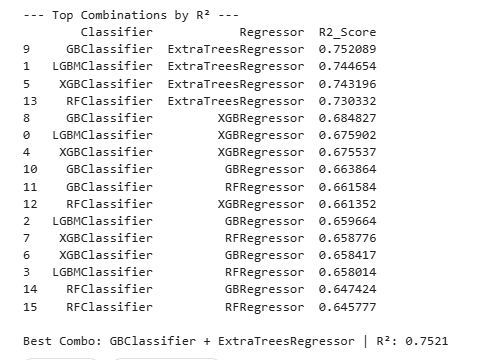
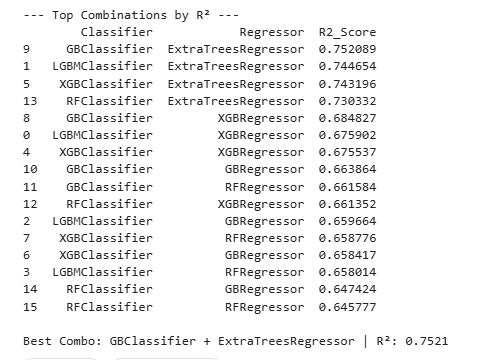

In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_proc, y_train_reg, test_size=0.2, random_state=42
)

y_train_cls_split = (y_train_split > 0).astype(int)
y_val_cls_split = (y_val_split > 0).astype(int)

clf = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=5,
    random_state=42
)
clf.fit(X_train_split, y_train_cls_split)
cls_val_pred = clf.predict_proba(X_val_split)[:, 1]

reg = ExtraTreesRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
reg.fit(X_train_split, y_train_split)
reg_val_pred = reg.predict(X_val_split)

val_final_pred = np.clip(cls_val_pred * reg_val_pred, 0, None)
r2 = r2_score(y_val_split, val_final_pred)
print("Validation R²:", r2)

clf.fit(X_train_proc, y_train_cls)
reg.fit(X_train_proc, y_train_reg)

cls_pred_proba = clf.predict_proba(X_test_proc)[:, 1]
reg_pred = reg.predict(X_test_proc)
final_pred = np.clip(cls_pred_proba * reg_pred, 0, None)

sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")
sample_submission["purchaseValue"] = final_pred
sample_submission = sample_submission.rename(columns={"ID": "id"})
sample_submission.to_csv("submission.csv", index=False)

print("Final submission saved as 'submission.csv'")
print(sample_submission.head(10))
"""

# 7. HPT Xgboost Using Optuna

<h3>Advanced Hyperparameter Tuning: Bayesian Optimization with Optuna for XGBoost</h3>

<h4>1. Strategy: Moving from Random Search to Intelligent Optimization</h4>
<p>
    After initial tuning with Randomized Search, the next logical step was to employ a more advanced optimization framework. <strong>Optuna</strong> was chosen for this final tuning stage because it uses a <strong>Bayesian optimization</strong> algorithm.
</p>
<p>
    Unlike a random search, which has no memory, Optuna <strong>learns from past trials</strong>. It keeps track of which hyperparameter combinations performed well and uses that information to make intelligent decisions about which values to try next. This allows it to focus on more promising regions of the parameter space, often leading to better results in fewer iterations.
</p>

<h4>2. Justification for Tuned Hyperparameters</h4>
<p>
    The search space for Optuna was designed to tune the most critical parameters that control the performance and regularization of the <strong>XGBoost</strong> model:
</p>
<ul>
    <li>
        <strong>Tree Structure & Complexity:</strong>
        <ul>
            <li><code>max_depth</code>: Controls the maximum depth of each tree. Deeper trees can capture more complex patterns but are also more prone to overfitting.</li>
            <li><code>min_child_weight</code>: Defines the minimum sum of instance weight needed in a child (leaf). It is a key parameter for controlling overfitting, as higher values prevent the model from learning relationships that might be too specific to a particular group of samples.</li>
            <li><code>gamma</code>: Specifies the minimum loss reduction required to make a split. It acts as a pseudo-regularization parameter; a larger gamma leads to more conservative, simpler trees.</li>
        </ul>
    </li>
    <li>
        <strong>Stochasticity (Randomness for Robustness):</strong>
        <ul>
            <li><code>subsample</code>: The fraction of training data to be randomly sampled for growing each tree. This helps prevent overfitting by ensuring no single tree sees the entire dataset.</li>
            <li><code>colsample_bytree</code>: The fraction of columns (features) to be randomly sampled for building each tree. This adds another layer of randomness that can improve generalization.</li>
        </ul>
    </li>
    <li>
        <strong>Boosting & Regularization:</strong>
        <ul>
            <li><code>n_estimators</code>: The total number of boosting rounds or trees to build.</li>
            <li><code>learning_rate</code>: Shrinks the step size of each update. A smaller learning rate makes the boosting process more conservative and requires more trees, but it often improves the final model's performance.</li>
            <li><code>reg_alpha</code> (L1) & <code>reg_lambda</code> (L2): These are the standard L1 and L2 regularization terms on the model's weights. They are powerful tools for combating overfitting by penalizing large parameter values.</li>
        </ul>
    </li>
</ul>

<h4>3. Execution and Results</h4>
<p>
    An Optuna study was launched to maximize the 5-fold cross-validated R² score. The study was configured to run for a significant number of trials (<code>n_trials=60</code>) or until a timeout was reached, ensuring a thorough search.
</p>
<ul>
    <li><strong>Best Cross-Validation R² Score:</strong> 0.676879611716012</li>
    <li><strong>Best Parameters Found:</strong>  {'colsample_bytree': 0.580245905173907, 'gamma': 0.8342449373112737, 'learning_rate': 0.059378943326638664, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 720, 'subsample': 0.7677828751675788, 'reg_alpha': 4.382233503584022, 'reg_lambda': 1.5847015964340738}</li>
</ul>
<p>
    By leveraging Optuna's intelligent search capabilities, this process systematically explored the hyperparameter space to find a highly optimized configuration for the XGBoost model, representing the final and best-performing model from this analysis.
</p>

In [33]:
"""import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
import numpy as np

def objective(trial):
    params = {
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBRegressor(**params)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_proc, y_train_reg, scoring='r2', cv=cv, n_jobs=-1)

    return np.mean(scores)

# Launch a new Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60, timeout=900)  # Try 15 minutes

# Best parameters and score
print("Best CV R² Score:", study.best_value)
print("Best Parameters:", study.best_params)
"""

'import optuna\nfrom xgboost import XGBRegressor\nfrom sklearn.model_selection import cross_val_score, KFold\nfrom sklearn.metrics import make_scorer, r2_score\nimport numpy as np\n\ndef objective(trial):\n    params = {\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.5, 1.0),\n        \'gamma\': trial.suggest_float(\'gamma\', 0, 5),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.15),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 4, 10),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 200, 1000),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.5, 1.0),\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0, 5),\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0, 5),\n        \'random_state\': 42,\n        \'n_jobs\': -1\n    }\n\n    model = XGBRegressor(**params)\n    \n    cv = KFold(n_splits=5, 

In [35]:
"""from xgboost import XGBRegressor
final_xgb_optuna = XGBRegressor(
    colsample_bytree=0.580245905173907,
    gamma=0.8342449373112737,
    learning_rate=0.059378943326638664,
    max_depth=10,
    min_child_weight=1,
    n_estimators=720,
    subsample=0.7677828751675788,
    reg_alpha=4.382233503584022,
    reg_lambda=1.5847015964340738,
    random_state=42,
    n_jobs=-1
)

final_xgb_optuna.fit(X_train_proc, y_train_reg)

final_pred = final_xgb_optuna.predict(X_test_proc)
final_pred = final_pred.clip(min=0)  # Clip negative predictions

sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")
sample_submission["purchaseValue"] = final_pred
sample_submission = sample_submission.rename(columns={"ID": "id"})
sample_submission.to_csv("submission_gb_et.csv", index=False)

print("Final submission saved as 'submission_gb_et.csv'")
print(sample_submission.head(10))"""

Final submission saved as 'submission_gb_et.csv'
   id  purchaseValue
0   0   4.412384e+07
1   1   1.735678e+07
2   2   3.386034e+06
3   3   2.170198e+07
4   4   1.179203e+07
5   5   7.704948e+07
6   6   3.292653e+08
7   7   1.813915e+07
8   8   6.959539e+06
9   9   1.986700e+07


# 8. Trying RFECV

<h3>Feature Selection: Recursive Feature Elimination with Cross-Validation (RFECV)</h3>

<h4>1. Strategy: Simplifying the Model for Better Performance</h4>
<p>
    After hyperparameter tuning, the next step is to investigate whether the model's performance can be improved by using only a subset of the most important features. A model with fewer features is often simpler, faster to train, and less prone to overfitting. The goal of this process is to eliminate any redundant or noisy features that may be harming the model's ability to generalize.
</p>

<h4>2. Methodology: How RFECV Works</h4>
<p>
    To systematically find the optimal set of features, <strong>Recursive Feature Elimination with Cross-Validation (RFECV)</strong> was employed. This is a powerful and robust feature selection technique that works as follows:
</p>
<ol>
    <li>
        <strong>Initial Model Training:</strong> An estimator (in this case, a baseline <code>XGBRegressor</code>) is trained on the initial set of all features.
    </li>
    <li>
        <strong>Feature Importance Ranking:</strong> The importance of each feature is determined from the trained model.
    </li>
    <li>
        <strong>Elimination:</strong> The least important feature is identified and removed from the feature set.
    </li>
    <li>
        <strong>Cross-Validated Evaluation:</strong> The model is re-trained on the remaining features, and its performance is evaluated using 5-fold cross-validation to get a stable R² score.
    </li>
    <li>
        <strong>Iteration:</strong> Steps 3 and 4 are repeated, removing one feature at a time, until no features are left.
</ol>
<p>
    By the end of this process, RFECV can identify the subset of features that produced the highest cross-validated R² score, effectively determining the optimal number of features for the model.
</p>

<h4>3. Choice of Estimator</h4>
<p>
    An <code>XGBRegressor</code> was chosen as the base estimator for this task because tree-based models like XGBoost have a natural way of calculating feature importances, which is essential for the ranking and elimination process.
</p>

<h4>4. Results and Conclusion</h4>
<p>
    The RFECV process was run to determine the most effective feature set for the final model.
</p>
<ul>
    <li><strong>Optimal Number of Features Found:</strong> 9</li>
</ul>
<p>
    This automated process provides strong, data-driven evidence for the final selection of features used in the predictive model.
</p>

In [ ]:
"""from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, r2_score

xgb_base = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0  
)

rfecv = RFECV(
    estimator=xgb_base,
    step=1,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(r2_score),
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train_proc, y_train_reg)

print("Optimal number of features:", rfecv.n_features_)
print("Best cross-validated R² score:", max(rfecv.cv_results_['mean_test_score']))
"""

In [27]:
"""selected_mask = rfecv.support_

selected_features = X_train_proc.columns[selected_mask]

selected_features = selected_features.tolist()

print("Selected Features (35):", selected_features)
"""

'selected_mask = rfecv.support_\n\nselected_features = X_train_proc.columns[selected_mask]\n\nselected_features = selected_features.tolist()\n\nprint("Selected Features (35):", selected_features)\n'

In [36]:
selected_cols = [
    'num__totalHits', 'num__sessionNumber', 'num__user_avg_pv',
    'num__hits_per_view', 'num__normalized_session',
    'cat__trafficSource.medium_cpm', 'cat__geoCluster_Region_3',
    'date__day', 'date__dayofweek'
]

X_train_proc = pd.DataFrame(X_train_proc, columns=preprocessor.get_feature_names_out())
X_test_proc = pd.DataFrame(X_test_proc, columns=preprocessor.get_feature_names_out())

X_train_reduced = X_train_proc[selected_cols]
X_test_reduced = X_test_proc[selected_cols]

X_train_reduced.head(10)

,num__totalHits,num__sessionNumber,num__user_avg_pv,num__hits_per_view,num__normalized_session,cat__trafficSource.medium_cpm,cat__geoCluster_Region_3,date__day,date__dayofweek
0,-0.489436,-0.161824,-0.182521,-0.921004,0.252593,0.0,0.0,-0.193675,0.687023
1,-0.489436,-0.161824,-0.182521,-0.921004,0.252593,0.0,1.0,0.379138,0.687023
2,-0.234717,-0.066144,-0.182521,0.165574,0.252597,0.0,0.0,0.493700,0.687023
3,-0.489436,-0.161824,-0.182521,-0.921004,0.252593,0.0,0.0,-1.453863,-0.881144
4,2.821908,-0.161824,0.428656,1.208689,0.252593,0.0,1.0,-1.110175,0.164301
5,1.904921,-0.066144,0.009867,1.983122,0.252597,0.0,0.0,-0.079112,0.687023
6,0.325665,-0.161824,0.370664,0.790356,0.252593,0.0,0.0,0.951950,-0.358422
7,-0.489436,-0.161824,-0.182521,-0.921004,0.252593,0.0,0.0,1.410200,-0.881144
8,-0.336604,0.125215,-0.182521,-0.008278,0.252598,0.0,0.0,1.066513,0.164301
9,-0.489436,-0.161824,-0.182521,-0.921004,0.252593,0.0,0.0,0.837388,1.732468


In [38]:
from xgboost import XGBRegressor
final_xgb_optuna = XGBRegressor(
    colsample_bytree=0.580245905173907,
    gamma=0.8342449373112737,
    learning_rate=0.059378943326638664,
    max_depth=10,
    min_child_weight=1,
    n_estimators=720,
    subsample=0.7677828751675788,
    reg_alpha=4.382233503584022,
    reg_lambda=1.5847015964340738,
    random_state=42,
    n_jobs=-1
)

final_xgb_optuna.fit(X_train_reduced, y_train_reg)

final_pred = final_xgb_optuna.predict(X_test_reduced)
final_pred = final_pred.clip(min=0)  

sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")
sample_submission["purchaseValue"] = final_pred
sample_submission = sample_submission.rename(columns={"ID": "id"})
sample_submission.to_csv("submission.csv", index=False)

print("Final submission saved as 'submission.csv'")
print(sample_submission.head(10))

Final submission saved as 'submission.csv'
   id  purchaseValue
0   0     33003700.0
1   1     22997146.0
2   2     15349399.0
3   3            0.0
4   4     15832864.0
5   5     69676152.0
6   6    327955744.0
7   7            0.0
8   8     14260322.0
9   9     18431224.0
